## Project 7 
Effectuez une prédiction de revenus --- Prediction of an income

You are an employee of a bank that operates in many countries around the world. The bank wants to target potential new customers, especially young people who are opening their first bank account. However, they want to target those prospects who are most likely to have high incomes later in life. So the team you work with has been tasked with creating a model to determine a person's income potential. So you propose a linear regression with 3 variables:
- parents' income ;
- the average income of the country in which the prospect lives;
- the Gini index calculated on the income of the inhabitants of the country in question. 

Libraries and data import

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st
from collections import Counter

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import statsmodels
import statsmodels.formula.api as smf
import statsmodels.api as sm # for qq plot, Question 4
from statsmodels.stats.outliers_influence import variance_inflation_factor

import pingouin as pg

In [2]:
### PANDAS SETTINGS
# change the format of floats from scientific into more readable
pd.options.display.float_format = '{:,.2f}'.format

### data import

In [3]:
workdir = 'C:/Users/aciag/Desktop/IDF OpenClassrooms/P7_Mykhailytskyi_Mykola' # instead of os module

world_income = pd.read_csv(workdir + '/data/data-projet7.csv', decimal=',')
world_gini = pd.read_csv(workdir + '/data/gini_index_data.csv', header=2)
population = pd.read_csv(workdir + '/data/world_population_data.csv', header=2)

missing_data = pd.read_csv(workdir + '/data/gdpppp_full_data.csv', header=2, decimal=',')

## Task 1

In [4]:
world_income.head(3)

,country,year_survey,quantile,nb_quantiles,income,gdpppp
0,ALB,2008,1,100,728.90,"7,297.00"
1,ALB,2008,2,100,916.66,"7,297.00"
2,ALB,2008,3,100,"1,010.92","7,297.00"


In [5]:
world_income.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11599 entries, 0 to 11598
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   country       11599 non-null  object 
 1   year_survey   11599 non-null  int64  
 2   quantile      11599 non-null  int64  
 3   nb_quantiles  11599 non-null  int64  
 4   income        11599 non-null  float64
 5   gdpppp        11399 non-null  float64
dtypes: float64(2), int64(3), object(1)
memory usage: 543.8+ KB


In [6]:
world_income.duplicated().sum()

# no dupes

0

In [7]:
# vérifier les valeurs manquantes
# check for missing values
print((world_income.isna().sum()/world_income.shape[0]*100).round(2))
print()
print(world_income.isna().sum())

# 200 missing rows (1.72% of col data)

country        0.00
year_survey    0.00
quantile       0.00
nb_quantiles   0.00
income         0.00
gdpppp         1.72
dtype: float64

country           0
year_survey       0
quantile          0
nb_quantiles      0
income            0
gdpppp          200
dtype: int64


In [8]:
world_income[world_income['gdpppp'].isna()]

,country,year_survey,quantile,nb_quantiles,income,gdpppp
5800,XKX,2008,1,100,437.89,NaN
5801,XKX,2008,2,100,508.17,NaN
5802,XKX,2008,3,100,591.83,NaN
5803,XKX,2008,4,100,668.00,NaN
5804,XKX,2008,5,100,730.40,NaN
...,...,...,...,...,...,...
11294,PSE,2009,96,100,"2,763.88",NaN
11295,PSE,2009,97,100,"3,077.83",NaN
11296,PSE,2009,98,100,"3,449.22",NaN
11297,PSE,2009,99,100,"4,166.00",NaN


In [9]:
world_income[world_income['gdpppp'].isna()].country.unique()

array(['XKX', 'PSE'], dtype=object)

PSE is Palestine\
XKX is Kosovo

In [10]:
world_income[world_income['gdpppp'].isna()].year_survey.unique()

array([2008, 2009], dtype=int64)

In [11]:
# add missing data for Palestine and Kosovo from the same source
# https://data.worldbank.org/indicator/NY.GDP.PCAP.PP.CD
missing_data.head(3)

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,Unnamed: 65
0,Aruba,ABW,"GDP per capita, PPP (current international $)",NY.GDP.PCAP.PP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,33567.5500169846,36829.0327743518,36779.429429343,37311.7503195981,37585.0250792115,38897.122666275,NaN,NaN,NaN,NaN
1,Africa Eastern and Southern,AFE,"GDP per capita, PPP (current international $)",NY.GDP.PCAP.PP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,3235.16335913109,3362.86880917301,3499.13287771861,3527.16419226322,3620.92150237861,3697.45930470822,3786.35731011396,3836.57142982939,3677.11125517431,NaN
2,Afghanistan,AFG,"GDP per capita, PPP (current international $)",NY.GDP.PCAP.PP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,1914.77422837964,2015.51477466948,2069.42402167356,2087.30532306683,1981.11806850696,2058.4002210698,2082.63564821362,2152.3664894209,2077.8745536104,NaN


In [12]:
missing_data.columns

Index(['Country Name', 'Country Code', 'Indicator Name', 'Indicator Code',
       '1960', '1961', '1962', '1963', '1964', '1965', '1966', '1967', '1968',
       '1969', '1970', '1971', '1972', '1973', '1974', '1975', '1976', '1977',
       '1978', '1979', '1980', '1981', '1982', '1983', '1984', '1985', '1986',
       '1987', '1988', '1989', '1990', '1991', '1992', '1993', '1994', '1995',
       '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004',
       '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013',
       '2014', '2015', '2016', '2017', '2018', '2019', '2020', 'Unnamed: 65'],
      dtype='object')

In [13]:
df_temp = missing_data[missing_data['Country Code'] == 'XKX']
df_temp = df_temp.append(missing_data[missing_data['Country Code'] == 'PSE'])
df_temp

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,Unnamed: 65
261,Kosovo,XKX,"GDP per capita, PPP (current international $)",NY.GDP.PCAP.PP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,8039.20797587196,8383.39731100106,8649.44949912369,9357.1351357728,10007.6892341976,10436.1688459323,11013.3970807579,11797.1193174485,11383.4047327921,NaN
196,West Bank and Gaza,PSE,"GDP per capita, PPP (current international $)",NY.GDP.PCAP.PP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,5255.82560942147,5371.68710020242,5510.13293040455,5954.40078363208,6305.39180301552,6401.74089135074,6469.90909814318,6509.56833548333,5687.82647498205,NaN


In [14]:
year_check = world_income[world_income['gdpppp'].isna()]

print(year_check[year_check['country'] == 'XKX'].year_survey.unique())
print(year_check[year_check['country'] == 'PSE'].year_survey.unique())

[2008]
[2009]


Kosovo data is only 2008, Palestine data is only 2009

In [15]:
# delete irrelevant cols
df_temp = df_temp.loc[:, ['Country Code', '2008', '2009']]
df_temp = df_temp.reset_index()
df_temp = df_temp.drop(columns='index')

In [16]:
# delete data from irrelevant country-year pair and rename col according to main df
df_temp.loc[0, 'gdpppp'] = df_temp.loc[0, '2008']
df_temp.loc[1, 'gdpppp'] = df_temp.loc[1, '2009']
df_temp = df_temp.drop(columns=['2008', '2009'])

df_temp

,Country Code,gdpppp
0,XKX,6539.17954476937
1,PSE,3951.23499279619


In [17]:
# put this data into project df
world_income.loc[world_income['country'].isin(['XKX']), 'gdpppp'] = df_temp.loc[0, 'gdpppp']
world_income.loc[world_income['country'].isin(['PSE']), 'gdpppp'] = df_temp.loc[1, 'gdpppp']

In [18]:
print((world_income.isna().sum()/world_income.shape[0]*100).round(2))
print()
print(world_income.isna().sum())

country        0.00
year_survey    0.00
quantile       0.00
nb_quantiles   0.00
income         0.00
gdpppp         0.00
dtype: float64

country         0
year_survey     0
quantile        0
nb_quantiles    0
income          0
gdpppp          0
dtype: int64


In [19]:
world_income.shape

(11599, 6)

### Number of countries

In [20]:
world_income['country'].nunique()

116

We have 116 countries.
100 quantiles per country means 11600 rows.
We miss one row.

In [21]:
row_miss = world_income.groupby('country')['quantile'].count().reset_index()
row_miss[row_miss['quantile'] != 100]

,country,quantile
62,LTU,99


LTU is Lithuania

In [22]:
# compte de 1 à 100 avec impression du quantile manquant
# count from 1 to 100 with printing missing quantile

for i in range(1,101):
    if i not in world_income[world_income['country'] == 'LTU']['quantile'].values:
        print("Missing quantile is number:", i)

#world_income.loc[(world_income['country'] == 'LTU') & (world_income['quantile'] < 50)]
#world_income.loc[(world_income['country'] == 'LTU') & (world_income['quantile'] > 50)]

Missing quantile is number: 41


In [23]:
# ajouter la ligne manquante de LTU basée sur la moyenne entre les quantiles 40 et 42 (devrait être plus facile que la manipulation des données complètes à partir du nouveau fichier csv)
# add LTU missing row based on avg between quantile 40 and 42 (should be easier than whole data manipulation from new csv file)

missing_ltu = world_income[(world_income['country'] == 'LTU') & ((world_income['quantile'] == 40) | (world_income['quantile'] == 42))]
missing_ltu

,country,year_survey,quantile,nb_quantiles,income,gdpppp
6239,LTU,2008,40,100,"4,868.45","17,571.00"
6240,LTU,2008,42,100,"4,895.83","17,571.00"


In [24]:
quantile41 = pd.DataFrame(({'country':'LTU', 'year_survey':2008, 'quantile':41, 'nb_quantiles':100, 'income':(round((missing_ltu['income'].values.sum()/2), 4)), 'gdpppp':17571.00}), index=[6239.5])
quantile41

,country,year_survey,quantile,nb_quantiles,income,gdpppp
"6,239.50",LTU,2008,41,100,"4,882.14","17,571.00"


In [25]:
# insérer une ligne avec de nouvelles données dans le projet df
# insert a row with new data into project df
world_income = world_income.append(quantile41, ignore_index=False)
world_income = world_income.sort_index().reset_index(drop=True)

# Attribuer le 41ème indice du quantile qui s'insère entre les indices existants, puis trier par cet indice et réinitialiser, ce qui donne de nouveaux indices corrects.
# assign 41st quantile index that fits between existing ones, then sort by it and reset, thus having new and correct indexes
world_income.iloc[6238:6243,:]

,country,year_survey,quantile,nb_quantiles,income,gdpppp
6238,LTU,2008,39,100,"4,802.37","17,571.00"
6239,LTU,2008,40,100,"4,868.45","17,571.00"
6240,LTU,2008,41,100,"4,882.14","17,571.00"
6241,LTU,2008,42,100,"4,895.83","17,571.00"
6242,LTU,2008,43,100,"4,950.64","17,571.00"


### years of data used

In [26]:
# Nombre d'années de données utilisées
world_income.groupby('year_survey').nunique()

,country,quantile,nb_quantiles,income,gdpppp
year_survey,,,,,
2004,1,100,1,100,1
2006,5,100,1,500,5
2007,15,100,1,1500,15
2008,76,100,1,7599,76
2009,12,100,1,1200,12
2010,6,100,1,600,6
2011,1,100,1,100,1


2008 has the most amout of countries (76)

In [27]:
world_income.describe()

,year_survey,quantile,nb_quantiles,income
count,"11,600.00","11,600.00","11,600.00","11,600.00"
mean,"2,007.98",50.50,100.00,"6,069.12"
std,0.91,28.87,0.00,"9,413.79"
min,"2,004.00",1.00,100.00,16.72
25%,"2,008.00",25.75,100.00,900.77
50%,"2,008.00",50.50,100.00,"2,403.49"
75%,"2,008.00",75.25,100.00,"7,515.31"
max,"2,011.00",100.00,100.00,"176,928.55"


In [28]:
world_income.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11600 entries, 0 to 11599
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   country       11600 non-null  object 
 1   year_survey   11600 non-null  int64  
 2   quantile      11600 non-null  int64  
 3   nb_quantiles  11600 non-null  int64  
 4   income        11600 non-null  float64
 5   gdpppp        11600 non-null  object 
dtypes: float64(1), int64(3), object(2)
memory usage: 543.9+ KB


In [29]:
# fixer le type de données gdpppp
# fix gdpppp data type
world_income['gdpppp'] = pd.to_numeric(world_income['gdpppp'])

In [30]:
world_income.describe()

,year_survey,quantile,nb_quantiles,income,gdpppp
count,"11,600.00","11,600.00","11,600.00","11,600.00","11,600.00"
mean,"2,007.98",50.50,100.00,"6,069.12","49,443.01"
std,0.91,28.87,0.00,"9,413.79","396,630.55"
min,"2,004.00",1.00,100.00,16.72,303.19
25%,"2,008.00",25.75,100.00,900.77,"2,577.50"
50%,"2,008.00",50.50,100.00,"2,403.49","7,532.50"
75%,"2,008.00",75.25,100.00,"7,515.31","18,196.25"
max,"2,011.00",100.00,100.00,"176,928.55","4,300,332.00"


gdpppp max is very large, might be an outlier or data error

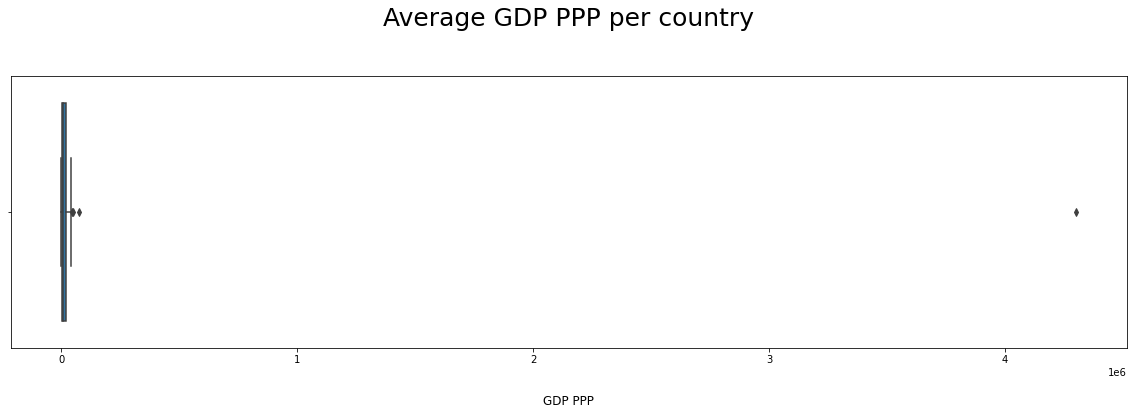

In [31]:
plt.figure(figsize = (20,5))

sns.boxplot(x='gdpppp', data=world_income.groupby('country')['gdpppp'].mean().reset_index(), orient='h')
plt.xlabel('GDP PPP', fontsize=12, labelpad=30)
plt.title('Average GDP PPP per country', fontsize=25, pad=50)

plt.savefig(fname='Avg_gdpppp_outliers.jpg', dpi=100, format='jpg', orientation='landscape', bbox_inches='tight')

plt.show();

In [32]:
# C'est la valeur aberrante de .describe, nous devons la chercher.
# that's the outlier from .describe, we need to look for it

world_income[world_income['gdpppp'] == world_income['gdpppp'].max()]

,country,year_survey,quantile,nb_quantiles,income,gdpppp
3200,FJI,2008,1,100,308.17,"4,300,332.00"
3201,FJI,2008,2,100,384.33,"4,300,332.00"
3202,FJI,2008,3,100,436.59,"4,300,332.00"
3203,FJI,2008,4,100,486.81,"4,300,332.00"
3204,FJI,2008,5,100,520.20,"4,300,332.00"
...,...,...,...,...,...,...
3295,FJI,2008,96,100,"5,481.08","4,300,332.00"
3296,FJI,2008,97,100,"6,205.61","4,300,332.00"
3297,FJI,2008,98,100,"7,265.13","4,300,332.00"
3298,FJI,2008,99,100,"9,553.19","4,300,332.00"


Fiji data is strange, more than 4 million gdpppp. Looking at https://data.worldbank.org/indicator/NY.GDP.PCAP.PP.CD?end=2008&locations=FJ&start=2008 we see value of 7777.739

In [33]:
# remplacer les données erronées de Fiji par les vraies, manuellement à nouveau
# replace wrong Fiji data with real one, manually again

world_income.loc[world_income['country'] == 'FJI'] = world_income.loc[world_income['country'] == 'FJI'].replace(4300332.00, 7777.739)
world_income.loc[world_income['country'] == 'FJI']

,country,year_survey,quantile,nb_quantiles,income,gdpppp
3200,FJI,2008,1,100,308.17,"7,777.74"
3201,FJI,2008,2,100,384.33,"7,777.74"
3202,FJI,2008,3,100,436.59,"7,777.74"
3203,FJI,2008,4,100,486.81,"7,777.74"
3204,FJI,2008,5,100,520.20,"7,777.74"
...,...,...,...,...,...,...
3295,FJI,2008,96,100,"5,481.08","7,777.74"
3296,FJI,2008,97,100,"6,205.61","7,777.74"
3297,FJI,2008,98,100,"7,265.13","7,777.74"
3298,FJI,2008,99,100,"9,553.19","7,777.74"


In [34]:
world_income.describe()

,year_survey,quantile,nb_quantiles,income,gdpppp
count,"11,600.00","11,600.00","11,600.00","11,600.00","11,600.00"
mean,"2,007.98",50.50,100.00,"6,069.12","12,438.24"
std,0.91,28.87,0.00,"9,413.79","13,095.97"
min,"2,004.00",1.00,100.00,16.72,303.19
25%,"2,008.00",25.75,100.00,900.77,"2,577.50"
50%,"2,008.00",50.50,100.00,"2,403.49","7,532.50"
75%,"2,008.00",75.25,100.00,"7,515.31","17,679.25"
max,"2,011.00",100.00,100.00,"176,928.55","73,127.00"


In [35]:
world_income[world_income['gdpppp'] == world_income['gdpppp'].max()]

,country,year_survey,quantile,nb_quantiles,income,gdpppp
6300,LUX,2008,1,100,"5,780.84","73,127.00"
6301,LUX,2008,2,100,"7,315.27","73,127.00"
6302,LUX,2008,3,100,"7,891.25","73,127.00"
6303,LUX,2008,4,100,"8,312.03","73,127.00"
6304,LUX,2008,5,100,"8,945.64","73,127.00"
...,...,...,...,...,...,...
6395,LUX,2008,96,100,"53,724.63","73,127.00"
6396,LUX,2008,97,100,"58,382.31","73,127.00"
6397,LUX,2008,98,100,"65,280.22","73,127.00"
6398,LUX,2008,99,100,"77,673.37","73,127.00"


Tout va bien maintenant, LUX est en haut avec une distribution plus régulière dans .describe().

Looks ok now, LUX is top with more even distribution in .describe()

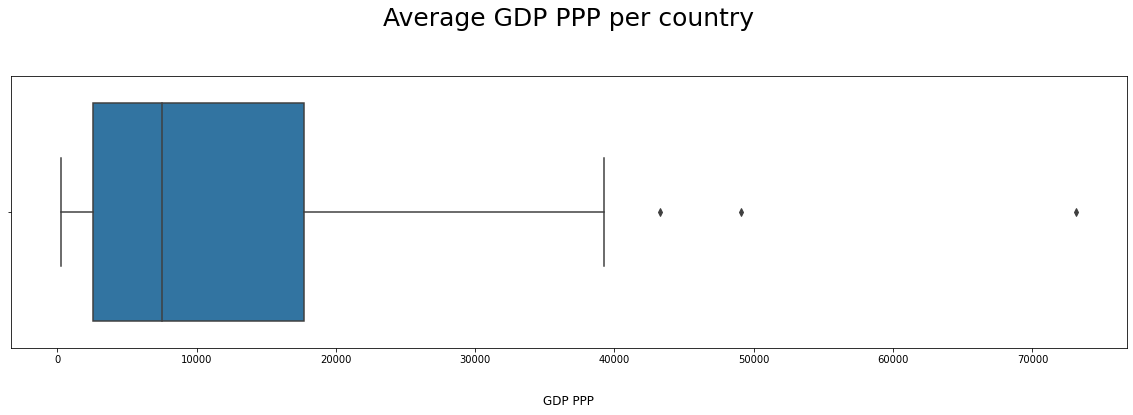

In [36]:
plt.figure(figsize = (20,5))

sns.boxplot(x='gdpppp', data=world_income.groupby('country')['gdpppp'].mean().reset_index(), orient='h')
plt.xlabel('GDP PPP', fontsize=12, labelpad=30)
plt.title('Average GDP PPP per country', fontsize=25, pad=50)

plt.savefig(fname='Avg_gdpppp.jpg', dpi=100, format='jpg', orientation='landscape', bbox_inches='tight')

plt.show();

In [37]:
# population
population.head(3)

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,Unnamed: 65
0,Aruba,ABW,"Population, total",SP.POP.TOTL,"54,208.00","55,434.00","56,234.00","56,699.00","57,029.00","57,357.00",...,"102,565.00","103,165.00","103,776.00","104,339.00","104,865.00","105,361.00","105,846.00","106,310.00","106,766.00",NaN
1,Africa Eastern and Southern,AFE,"Population, total",SP.POP.TOTL,"130,836,765.00","134,159,786.00","137,614,644.00","141,202,036.00","144,920,186.00","148,769,974.00",...,"547,482,863.00","562,601,578.00","578,075,373.00","593,871,847.00","609,978,946.00","626,392,880.00","643,090,131.00","660,046,272.00","677,243,299.00",NaN
2,Afghanistan,AFG,"Population, total",SP.POP.TOTL,"8,996,967.00","9,169,406.00","9,351,442.00","9,543,200.00","9,744,772.00","9,956,318.00",...,"31,161,378.00","32,269,592.00","33,370,804.00","34,413,603.00","35,383,028.00","36,296,111.00","37,171,922.00","38,041,757.00","38,928,341.00",NaN


In [38]:
print(population.columns)
print(population.shape)

Index(['Country Name', 'Country Code', 'Indicator Name', 'Indicator Code',
       '1960', '1961', '1962', '1963', '1964', '1965', '1966', '1967', '1968',
       '1969', '1970', '1971', '1972', '1973', '1974', '1975', '1976', '1977',
       '1978', '1979', '1980', '1981', '1982', '1983', '1984', '1985', '1986',
       '1987', '1988', '1989', '1990', '1991', '1992', '1993', '1994', '1995',
       '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004',
       '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013',
       '2014', '2015', '2016', '2017', '2018', '2019', '2020', 'Unnamed: 65'],
      dtype='object')
(266, 66)


In [39]:
# ne garder que les colonnes et les données pertinentes
# keep only relevant columns and data

population = population.loc[:, ['Country Name', 'Country Code', 'Indicator Name', '2004', '2006', '2007', '2008', '2009', '2010', '2011']]
population = population.reset_index()
population = population.drop(columns='index')
population = population.rename(columns={'Country Code':'country', 'Country Name':'country_name'}) #match world_income df

population.head(3)

,country_name,country,Indicator Name,2004,2006,2007,2008,2009,2010,2011
0,Aruba,ABW,"Population, total","98,744.00","100,830.00","101,226.00","101,362.00","101,452.00","101,665.00","102,050.00"
1,Africa Eastern and Southern,AFE,"Population, total","441,630,149.00","465,581,372.00","478,166,911.00","491,173,160.00","504,604,672.00","518,468,229.00","532,760,424.00"
2,Afghanistan,AFG,"Population, total","24,726,689.00","26,433,058.00","27,100,542.00","27,722,281.00","28,394,806.00","29,185,511.00","30,117,411.00"


In [40]:
print(population.isna().sum())

country_name      0
country           0
Indicator Name    0
2004              1
2006              1
2007              1
2008              1
2009              1
2010              1
2011              1
dtype: int64


In [41]:
display(population[population['2011'].isna()])
display(population[population['2004'].isna()])

# ressemble à une ligne vide, je ne trouve pas de pays avec ce code ISO
# supprimez-la
# looks like an empty row, cant find country with such ISO code
# delete it

population = population.dropna()

,country_name,country,Indicator Name,2004,2006,2007,2008,2009,2010,2011
110,Not classified,INX,"Population, total",NaN,NaN,NaN,NaN,NaN,NaN,NaN


,country_name,country,Indicator Name,2004,2006,2007,2008,2009,2010,2011
110,Not classified,INX,"Population, total",NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [42]:
# séparer chaque année dans son propre df pour le fusionner plus tard
# separate each year into its own df for merging later
pop2004 = population[['country_name', 'country', '2004']].copy()
pop2006 = population[['country_name', 'country', '2006']].copy()
pop2007 = population[['country_name', 'country', '2007']].copy()
pop2008 = population[['country_name', 'country', '2008']].copy()
pop2009 = population[['country_name', 'country', '2009']].copy()
pop2010 = population[['country_name', 'country', '2010']].copy()
pop2011 = population[['country_name', 'country', '2011']].copy()

# renommer et ajouter des colonnes pour le rendre similaire à world_income df
# rename and add cols to make it similar to world_income df
pop2004['year_survey'] = 2004
pop2006['year_survey'] = 2006
pop2007['year_survey'] = 2007
pop2008['year_survey'] = 2008
pop2009['year_survey'] = 2009
pop2010['year_survey'] = 2010
pop2011['year_survey'] = 2011

pop2004 = pop2004.rename(columns={'2004':'population'})
pop2006 = pop2006.rename(columns={'2006':'population'})
pop2007 = pop2007.rename(columns={'2007':'population'})
pop2008 = pop2008.rename(columns={'2008':'population'})
pop2009 = pop2009.rename(columns={'2009':'population'})
pop2010 = pop2010.rename(columns={'2010':'population'})
pop2011 = pop2011.rename(columns={'2011':'population'})

# fusionner ensemble toutes les années existantes
# merge together all existing years
population = pd.concat((pop2004, pop2006, pop2007, pop2008, pop2009, pop2010, pop2011))

df_global = pd.merge(world_income, population, on=('country', 'year_survey'), how='left')
df_global = df_global[['country_name', 'country', 'year_survey', 'quantile', 'nb_quantiles', 'income', 'gdpppp', 'population']]

In [43]:
display(world_income.head(3))

display(df_global.head(3))

,country,year_survey,quantile,nb_quantiles,income,gdpppp
0,ALB,2008,1,100,728.90,"7,297.00"
1,ALB,2008,2,100,916.66,"7,297.00"
2,ALB,2008,3,100,"1,010.92","7,297.00"


,country_name,country,year_survey,quantile,nb_quantiles,income,gdpppp,population
0,Albania,ALB,2008,1,100,728.90,"7,297.00","2,947,314.00"
1,Albania,ALB,2008,2,100,916.66,"7,297.00","2,947,314.00"
2,Albania,ALB,2008,3,100,"1,010.92","7,297.00","2,947,314.00"


In [44]:
print(df_global.duplicated().sum())
print(df_global.isna().sum())

0
country_name    100
country           0
year_survey       0
quantile          0
nb_quantiles      0
income            0
gdpppp            0
population      100
dtype: int64


pas de doublons, mais 100 lignes manquantes

no dupes, but 100 rows are missing

In [45]:
df_global[df_global['country_name'].isna()]

,country_name,country,year_survey,quantile,nb_quantiles,income,gdpppp,population
10400,NaN,TWN,2008,1,100,"3,477.18","25,342.00",NaN
10401,NaN,TWN,2008,2,100,"4,740.26","25,342.00",NaN
10402,NaN,TWN,2008,3,100,"5,331.30","25,342.00",NaN
10403,NaN,TWN,2008,4,100,"5,761.66","25,342.00",NaN
10404,NaN,TWN,2008,5,100,"6,093.20","25,342.00",NaN
...,...,...,...,...,...,...,...,...
10495,NaN,TWN,2008,96,100,"38,123.46","25,342.00",NaN
10496,NaN,TWN,2008,97,100,"41,663.79","25,342.00",NaN
10497,NaN,TWN,2008,98,100,"46,650.58","25,342.00",NaN
10498,NaN,TWN,2008,99,100,"54,016.99","25,342.00",NaN


TWN est Taiwan.\
Selon une recherche sur Internet, TWN comptait 23 037 031 habitants en 2008.\
Nous pouvons insérer les données brutes directement (méthode plus simple par rapport à PSE et XKX).

TWN is Taiwan.\
according to internet search, TWN in 2008 had 23,037,031 inhabitants.\
We can insert raw data directly (simpler way compared to PSE and XKX).\
https://en.wikipedia.org/wiki/Demographics_of_Taiwan#Population_census

In [46]:
df_global.loc[df_global['country'] == 'TWN', 'country_name'] = 'Taïwan'
df_global.loc[df_global['country'] == 'TWN', 'population'] = 23037031
df_global['population'] = df_global['population'].astype(int)

In [47]:
print(df_global.isna().sum())

country_name    0
country         0
year_survey     0
quantile        0
nb_quantiles    0
income          0
gdpppp          0
population      0
dtype: int64


In [48]:
# population totale dans nos données
# total population in our data
our_pop = df_global.groupby('country')['population'].unique().reset_index()['population'].astype(int).sum()
our_pop

6188499357

In [49]:
df_global.year_survey.unique()

array([2008, 2009, 2010, 2007, 2006, 2011, 2004], dtype=int64)

In [50]:
# Nous prenons la population mondiale de la même source que nos données principales.
# we take global population from same source as our main data
# https://data.worldbank.org/indicator/SP.POP.TOTL?end=2011&start=2004&type=shaded&view=chart
tp2004 = 6432000000
tp2006 = 6593000000
tp2007 = 6674000000
tp2008 = 6757000000
tp2009 = 6840000000
tp2010 = 6922000000
tp2011 = 7004000000
tp_avg = (tp2004+tp2006+tp2007+tp2008+tp2009+tp2010+tp2011) / 7

### Population covered by analysis

In [51]:
# Population couverte dans df_global (toutes les années que nous avons)
# population covered in df_global (all years that we have)

print(str(our_pop * 100 / tp_avg) + ' %')

91.7358339312185 %


PPP\
PPP est l'abréviation de Parité de Pouvoir d'Achat. Son objectif est de ramener les différentes monnaies du monde à une seule unité de mesure. Cette unité unique nous permet de comprendre de quelle quantité de monnaie spécifique nous avons besoin pour acheter un panier de biens standardisés.
Similaire à l'indice BigMac.

PPP stands for Purchasing Power Parity. Its goal is to bring many different currencies of the world to one, single unit of measure. This single unit allows us to understand, how much of specific currency we need in order to buy standardized basket of goods.
Similar to BigMac index.
More info:
https://en.wikipedia.org/wiki/Purchasing_power_parity
https://www.investopedia.com/updates/purchasing-power-parity-ppp/

Quantiles\
Nos données divisent les revenus en cent groupes de taille égale. Quel que soit le pays ou ses performances économiques, grâce à cette répartition des données, nous pouvons effectuer des comparaisons appropriées. Par exemple, à quel point le percentile le plus pauvre est pauvre dans différents pays, à quel point les riches sont riches ou ce qu'est une classe moyenne au 50e percentile.
La valeur ajoutée réside dans la facilité d'application d'autres outils économiques (indice de Gini et courbe de Lorenz), qui peuvent être utilisés pour enrichir notre analyse.

Our data splits incomes into one hundred equal-sized groups. No matter the country or its economic performance, thanks to divinding data this way we can make proper comparisons. For example how poor is the poorest percentile in different countries, how rich are the riches or what is a middle class at the 50th percentile.
Added value lies in ease of application of other economical tools (Gini index and Lorenz curve), that can be used to  enrich our analysis.

## Task 2

In [52]:
#world_gini = pd.read_csv(workdir + '/data/gini_index_data.csv', header=2)

In [53]:
world_gini.head(3)

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,Unnamed: 65
0,Aruba,ABW,Gini index (World Bank estimate),SI.POV.GINI,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Africa Eastern and Southern,AFE,Gini index (World Bank estimate),SI.POV.GINI,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Afghanistan,AFG,Gini index (World Bank estimate),SI.POV.GINI,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [54]:
print(world_gini.columns)
print(world_gini.shape)

Index(['Country Name', 'Country Code', 'Indicator Name', 'Indicator Code',
       '1960', '1961', '1962', '1963', '1964', '1965', '1966', '1967', '1968',
       '1969', '1970', '1971', '1972', '1973', '1974', '1975', '1976', '1977',
       '1978', '1979', '1980', '1981', '1982', '1983', '1984', '1985', '1986',
       '1987', '1988', '1989', '1990', '1991', '1992', '1993', '1994', '1995',
       '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004',
       '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013',
       '2014', '2015', '2016', '2017', '2018', '2019', '2020', 'Unnamed: 65'],
      dtype='object')
(266, 66)


In [55]:
world_gini = world_gini.rename(columns={'Country Name':'country_name', 'Country Code':'country'})
world_gini = world_gini.loc[:, ['country_name', 'country', 'Indicator Name', '2004', '2006', '2007', '2008', '2009', '2010', '2011']]
world_gini = world_gini.reset_index()
world_gini = world_gini.drop(columns='index')

world_gini

,country_name,country,Indicator Name,2004,2006,2007,2008,2009,2010,2011
0,Aruba,ABW,Gini index (World Bank estimate),NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Africa Eastern and Southern,AFE,Gini index (World Bank estimate),NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Afghanistan,AFG,Gini index (World Bank estimate),NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Africa Western and Central,AFW,Gini index (World Bank estimate),NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Angola,AGO,Gini index (World Bank estimate),NaN,NaN,NaN,42.70,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
261,Kosovo,XKX,Gini index (World Bank estimate),NaN,30.30,NaN,NaN,31.80,33.30,27.80
262,"Yemen, Rep.",YEM,Gini index (World Bank estimate),NaN,NaN,NaN,NaN,NaN,NaN,NaN
263,South Africa,ZAF,Gini index (World Bank estimate),NaN,NaN,NaN,63.00,NaN,63.40,NaN
264,Zambia,ZMB,Gini index (World Bank estimate),54.30,54.60,NaN,NaN,NaN,55.60,NaN


In [56]:
# séparer chaque année dans son propre df pour le fusionner plus tard
# separate each year into its own df for merging later
gini2004 = world_gini[['country_name', 'country', '2004']].copy()
gini2006 = world_gini[['country_name', 'country', '2006']].copy()
gini2007 = world_gini[['country_name', 'country', '2007']].copy()
gini2008 = world_gini[['country_name', 'country', '2008']].copy()
gini2009 = world_gini[['country_name', 'country', '2009']].copy()
gini2010 = world_gini[['country_name', 'country', '2010']].copy()
gini2011 = world_gini[['country_name', 'country', '2011']].copy()
 
gini2004['year_survey'] = 2004
gini2006['year_survey'] = 2006
gini2007['year_survey'] = 2007
gini2008['year_survey'] = 2008
gini2009['year_survey'] = 2009
gini2010['year_survey'] = 2010
gini2011['year_survey'] = 2011

# renommer et ajouter des colonnes pour le rendre similaire à world_income df
# rename and add cols to make it similar to world_income df
gini2004 = gini2004.rename(columns={'2004':'gini'})
gini2006 = gini2006.rename(columns={'2006':'gini'})
gini2007 = gini2007.rename(columns={'2007':'gini'})
gini2008 = gini2008.rename(columns={'2008':'gini'})
gini2009 = gini2009.rename(columns={'2009':'gini'})
gini2010 = gini2010.rename(columns={'2010':'gini'})
gini2011 = gini2011.rename(columns={'2011':'gini'})

gini_global = pd.concat((gini2004, gini2006, gini2007, gini2008, gini2009, gini2010, gini2011))

df_global = pd.merge(df_global, gini_global, on=('country_name', 'country', 'year_survey'), how='left')
df_global = df_global[['country_name', 'country', 'year_survey', 'quantile', 'nb_quantiles', 'income', 'gdpppp', 'population', 'gini']]
df_global['gini'] = df_global['gini'].astype(float)

In [57]:
df_global

,country_name,country,year_survey,quantile,nb_quantiles,income,gdpppp,population,gini
0,Albania,ALB,2008,1,100,728.90,"7,297.00",2947314,30.00
1,Albania,ALB,2008,2,100,916.66,"7,297.00",2947314,30.00
2,Albania,ALB,2008,3,100,"1,010.92","7,297.00",2947314,30.00
3,Albania,ALB,2008,4,100,"1,086.91","7,297.00",2947314,30.00
4,Albania,ALB,2008,5,100,"1,132.70","7,297.00",2947314,30.00
...,...,...,...,...,...,...,...,...,...
11595,"Congo, Dem. Rep.",COD,2008,96,100,810.62,303.19,60411195,NaN
11596,"Congo, Dem. Rep.",COD,2008,97,100,911.78,303.19,60411195,NaN
11597,"Congo, Dem. Rep.",COD,2008,98,100,"1,057.81",303.19,60411195,NaN
11598,"Congo, Dem. Rep.",COD,2008,99,100,"1,286.60",303.19,60411195,NaN


In [58]:
# search for missing gini
missing_gini = df_global.groupby(['country_name', 'country', 'year_survey'])['gini'].mean().reset_index()
missing_gini = missing_gini[missing_gini['gini'].isna()]
missing_gini.head(3)

,country_name,country,year_survey,gini
4,Azerbaijan,AZE,2008,NaN
14,Cambodia,KHM,2008,NaN
16,Canada,CAN,2008,NaN


In [59]:
print(missing_gini.country_name.unique())
print(missing_gini.country_name.nunique())

['Azerbaijan' 'Cambodia' 'Canada' 'China' 'Congo, Dem. Rep.' 'Croatia'
 'Egypt, Arab Rep.' 'Ghana' 'Guatemala' 'India' 'Iran, Islamic Rep.'
 'Iraq' 'Israel' 'Kenya' 'Kosovo' 'Malaysia' 'Mali' 'Montenegro' 'Morocco'
 'Nigeria' 'North Macedonia' 'Pakistan' 'Serbia' 'Sri Lanka'
 'Syrian Arab Republic' 'Taïwan' 'Yemen, Rep.']
27


In [60]:
# calculate gini manually

def CalcGini(data, sort):
    
    wealth = data[sort].values
    lorenz = np.cumsum(np.sort(wealth)) / wealth.sum()
    lorenz = np.append([0],lorenz) 
    curve = lorenz[:-1].sum()/len(lorenz)
    S = 0.5 - curve
    gini = 2*S*100
    return gini

for i,row in enumerate(df_global.values):
    sort = 'income'

    x = df_global[df_global['country'] == row[1]].copy()
    x = x.sort_values(by=sort)
    x = x.reset_index()
    x = x.drop(columns='index')

    df_global.loc[i,'gini_manual'] = CalcGini(x, sort)

In [61]:
df_global.gini_manual.isna().sum()

0

In [62]:
# List of countries to represent in Task 2

df_global.groupby('country_name').agg({'income' : 'mean', 'gdpppp' : 'mean', 'gini_manual' : 'mean', 'population' : 'mean'}).sort_values(['income'], ascending=False).head(10)

,income,gdpppp,gini_manual,population
country_name,,,,
Iceland,"26,888.51","36,527.00",30.20,317414
United States,"25,503.58","43,261.00",44.73,304093966
Luxembourg,"25,217.56","73,127.00",30.98,488650
Canada,"23,739.64","35,895.00",36.66,33247118
Norway,"22,483.38","49,070.00",28.01,4768212
United Kingdom,"21,709.60","34,048.00",35.58,61806995
France,"18,309.41","30,357.00",34.56,64374979
Germany,"18,061.72","33,758.00",32.32,82110097
Netherlands,"17,728.64","38,065.00",30.47,16445593


Top 5 by avg income are Iceland, United States, Luxembourg, Canada, Norway.

In [63]:
df_global.groupby('country_name').agg({'income' : 'mean', 'gdpppp' : 'mean', 'gini_manual' : 'mean', 'population' : 'mean'}).sort_values(['income'], ascending=True).head(10)

,income,gdpppp,gini_manual,population
country_name,,,,
"Congo, Dem. Rep.",276.02,303.19,45.94,60411195
Madagascar,345.24,950.00,45.60,21151640
Cote d'Ivoire,399.84,"1,526.00",43.06,19605568
Kenya,519.32,"1,429.00",31.58,38705934
Eswatini,530.28,"4,748.00",47.87,1057462
Tanzania,588.77,"1,201.00",39.18,40681416
Liberia,615.01,372.00,39.69,3461911
Niger,650.13,631.00,38.92,14685404
Mali,681.08,929.53,34.68,15049352


Lowest 5 by avg income are Congo, Madagascar, Cote d'Ivoire, Kenya, Eswatini

In [64]:
df_global.groupby('country_name').agg({'income' : 'mean', 'gdpppp' : 'mean', 'gini_manual' : 'mean', 'population' : 'mean'}).describe()

,income,gdpppp,gini_manual,population
count,116.00,116.00,116.00,116.00
mean,"6,069.12","12,438.24",39.50,"53,349,132.39"
std,"6,660.97","13,152.22",8.89,"167,074,811.97"
min,276.02,303.19,24.82,"317,414.00"
25%,"1,374.27","2,577.50",32.71,"4,698,545.00"
50%,"3,287.17","7,532.50",37.71,"14,528,627.50"
75%,"7,077.90","17,679.25",45.14,"39,049,490.25"
max,"26,888.51","73,127.00",68.29,"1,317,885,000.00"


Average income is 6069

In [65]:
# Nous utiliserons les 4 premiers et les 4 derniers, plus l'Ukraine et la France.
# we will use top 4 and bottom 4, plus Ukraine and France

countries = df_global[(df_global['country'] == 'ISL') ^ (df_global['country'] == 'USA') ^ (df_global['country'] == 'LUX') ^ (df_global['country'] == 'CAN') ^
                      (df_global['country'] == 'COD') ^ (df_global['country'] == 'MDG') ^ (df_global['country'] == 'CIV') ^ (df_global['country'] == 'KEN') ^ 
                      (df_global['country'] == 'UKR') ^ (df_global['country'] == 'FRA')]

countries.sample(5)

,country_name,country,year_survey,quantile,nb_quantiles,income,gdpppp,population,gini,gini_manual
3340,France,FRA,2008,41,100,"13,303.77","30,357.00",64374979,33.00,34.56
10928,United States,USA,2008,29,100,"12,000.02","43,261.00",304093966,40.80,44.73
5424,Kenya,KEN,2007,25,100,313.78,"1,429.00",38705934,NaN,31.58
11528,"Congo, Dem. Rep.",COD,2008,29,100,125.39,303.19,60411195,NaN,45.94
1824,Cote d'Ivoire,CIV,2008,25,100,181.54,"1,526.00",19605568,43.20,43.06


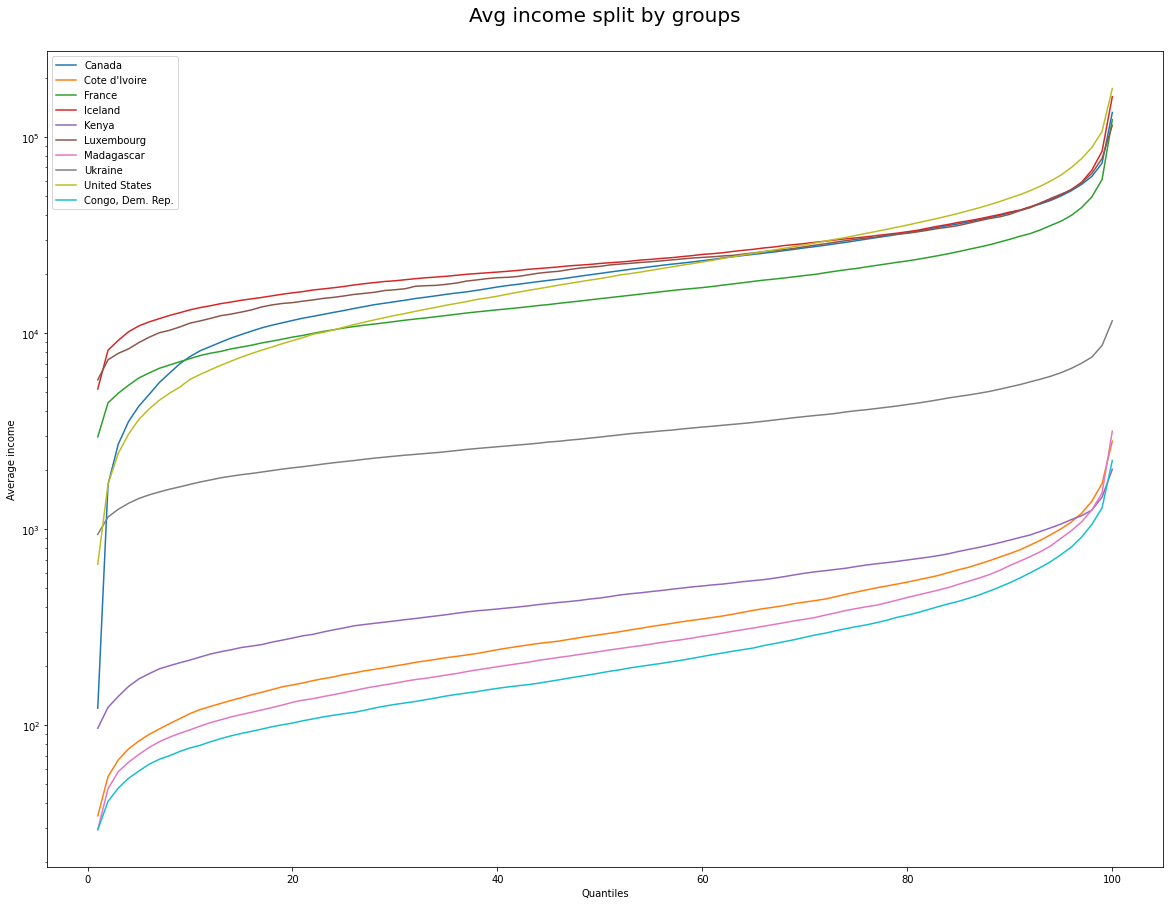

In [66]:
# visualization

plt.figure(figsize=(20, 15))

sns.lineplot(x=countries['quantile'], y=countries['income'], data=countries, hue=countries['country_name'])
plt.xlabel("Quantiles")
plt.ylabel("Average income")
plt.yscale("Log")
plt.legend()
plt.title("Avg income split by groups", pad=30, fontsize=20)

plt.savefig(fname='Avg_income_QQplot.jpg', dpi=100, format='jpg', orientation='landscape', bbox_inches='tight')

plt.show();

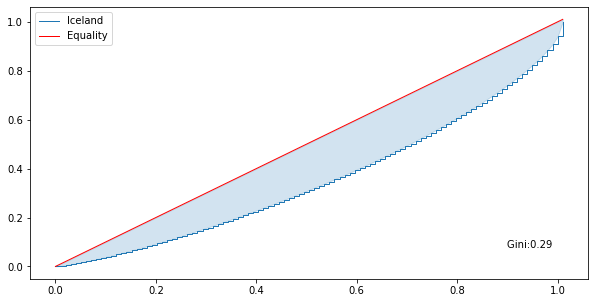

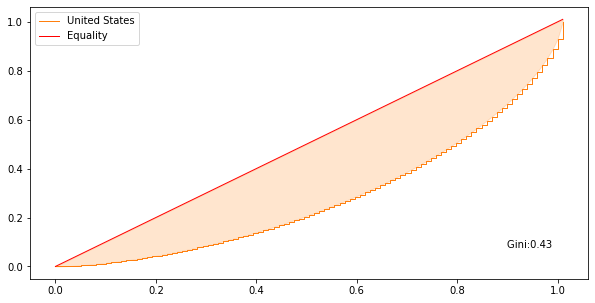

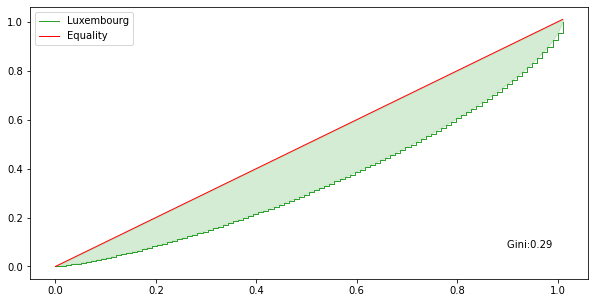

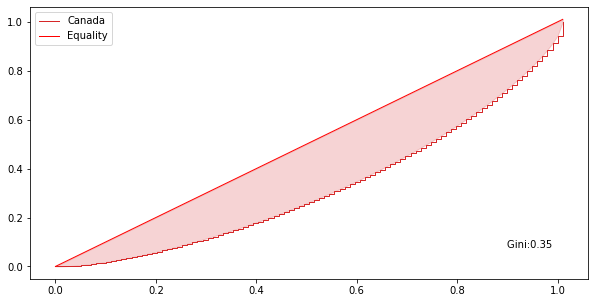

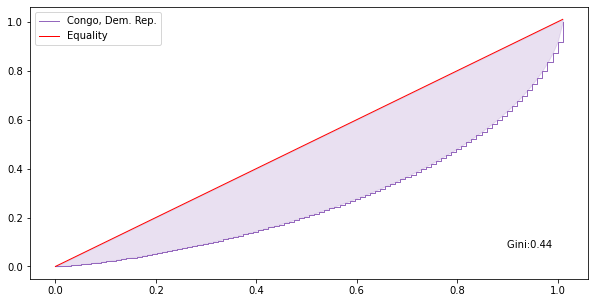

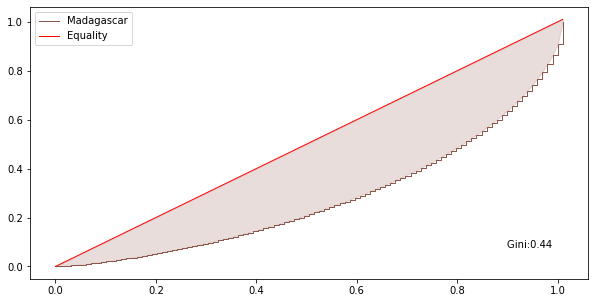

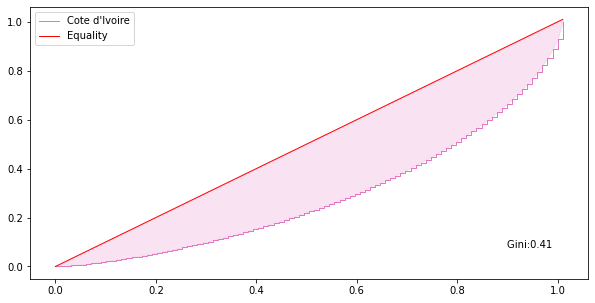

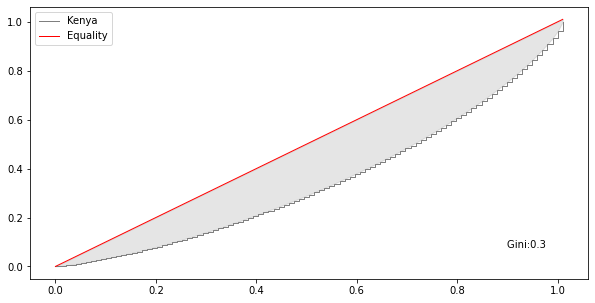

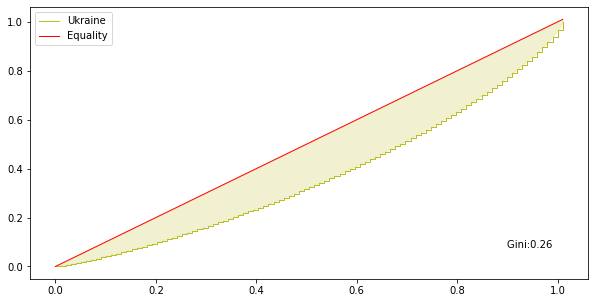

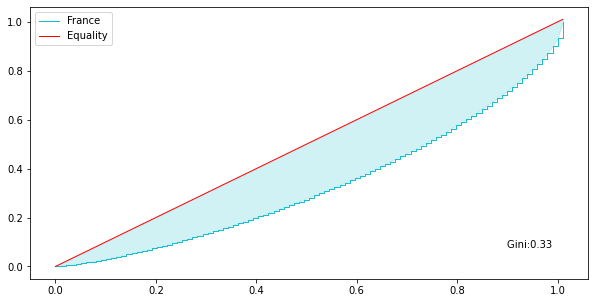

In [67]:
# Lorenz curves

d = dict()

colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:grey', 'tab:olive', 'tab:cyan']

for country, color in zip(['ISL', 'USA', 'LUX', 'CAN', 'COD', 'MDG', 'CIV', 'KEN', 'UKR', 'FRA'], colors):
    
    d[country] = countries[countries['country'] == country]
    income = d[country]['income'].values
    n = len(income)
    lorenz = np.cumsum(np.sort(income)) / income.sum()
    lorenz = np.append([0], lorenz)
    xaxis = np.linspace(0.01-1/n,1+1/n,n+1)
    X = np.arange(0,1.02,0.01)
    Y = X

    AUC = (lorenz.sum() - lorenz[-1]/2 - lorenz[0]/2) / n 
    S = 0.5 - AUC 
    Gini = 2*S

    #visualization
    plt.figure(figsize=(10,5))
    plt.plot(xaxis, lorenz, drawstyle='steps-post', label=d[country]['country_name'].unique()[0], lw=1, color=color)
    plt.plot(X, Y, lw=1, label = 'Equality', color='red')
    plt.fill_between(xaxis, lorenz, xaxis, color=color, alpha=0.2)
    plt.text(0.9, 0.075, 'Gini:%s ' %round(Gini,2))
    plt.legend()
    plt.savefig(fname=f'Lorenz_curve_{country}.jpg', dpi=100, format='jpg', orientation='landscape', bbox_inches='tight')
    plt.show();

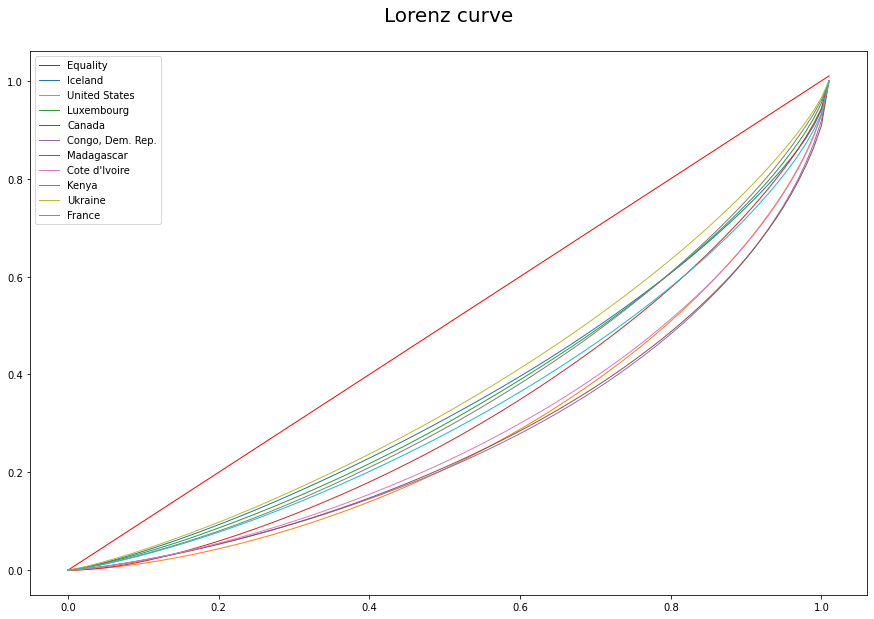

In [68]:
# single graph

colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:grey', 'tab:olive', 'tab:cyan']

plt.figure(figsize=(15, 10))
plt.plot(X, Y, color='red', lw=1, label = 'Equality') 
    
for country, color in zip(['ISL', 'USA', 'LUX', 'CAN', 'COD', 'MDG', 'CIV', 'KEN', 'UKR', 'FRA'], colors):

    d[country] = countries[countries['country'] == country]
    income = d[country]['income'].values
    n = len(income)
    lorenz = np.cumsum(np.sort(income)) / income.sum()
    lorenz = np.append([0],lorenz)   
    plt.plot(xaxis, lorenz, label=d[country]['country_name'].unique()[0], lw=1, color=color)
    plt.legend()
    plt.title("Lorenz curve", fontsize=20, pad=30)

plt.savefig(fname=f'Lorenz_curves_combined.jpg', dpi=100, format='jpg', orientation='landscape', bbox_inches='tight')
plt.show();

In [69]:
# L'évolution du gini dans le temps
# gini changes over time

gini_countries = world_gini[(world_gini['country'] == 'ISL') ^ (world_gini['country'] == 'USA') ^
                            (world_gini['country'] == 'LUX') ^ (world_gini['country'] == 'CAN') ^
                            (world_gini['country'] == 'COD') ^ (world_gini['country'] == 'MDG') ^
                            (world_gini['country'] == 'CIV') ^ (world_gini['country'] == 'KEN') ^
                            (world_gini['country'] == 'UKR') ^ (world_gini['country'] == 'FRA')]

gini_countries = gini_countries[['country', '2004', '2006', '2007', '2008', '2009', '2010', '2011']].sort_values(by='country')

gini_countries

# cant do that with manual gini, so which one is better then?

,country,2004,2006,2007,2008,2009,2010,2011
35,CAN,33.70,NaN,33.80,NaN,NaN,33.60,NaN
41,CIV,NaN,NaN,NaN,43.20,NaN,NaN,NaN
43,COD,42.20,NaN,NaN,NaN,NaN,NaN,NaN
77,FRA,30.60,29.70,32.40,33.00,32.70,33.70,33.30
114,ISL,28.00,30.20,29.50,31.80,28.70,26.20,26.80
121,KEN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
144,LUX,30.20,30.90,31.10,32.60,31.20,30.50,32.10
151,MDG,NaN,NaN,NaN,NaN,NaN,42.40,NaN
248,UKR,28.90,29.80,27.00,26.60,25.30,24.80,24.60
251,USA,40.30,41.40,40.80,40.80,40.60,40.00,40.90


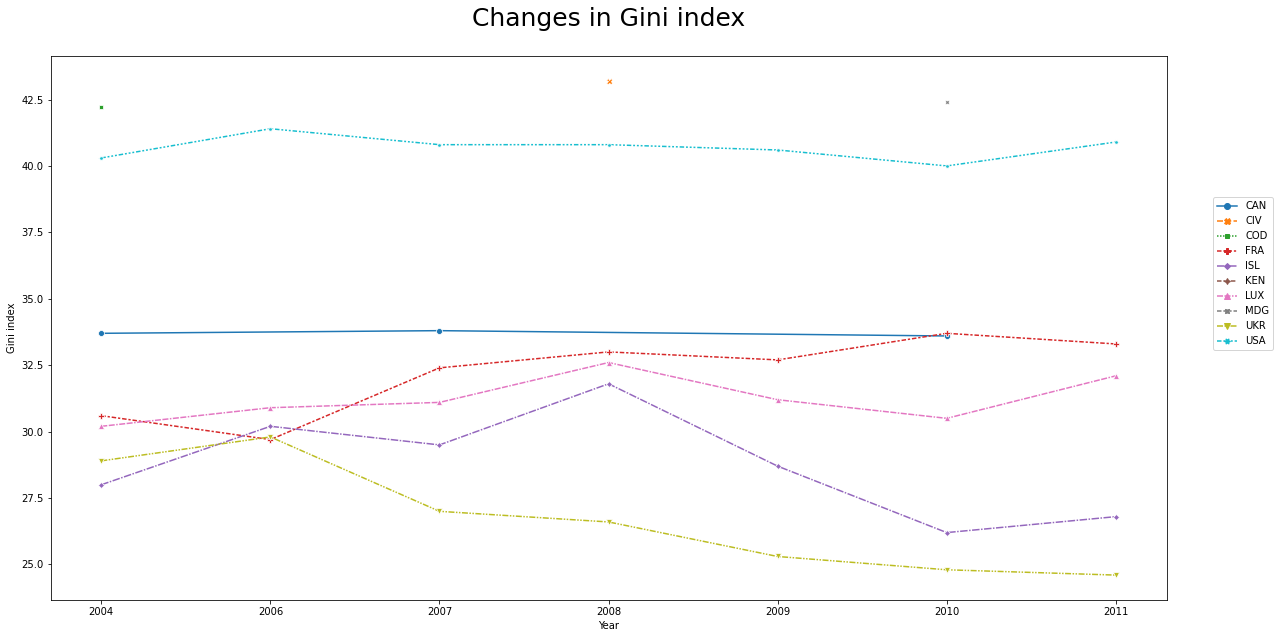

In [70]:
plt.figure(figsize=(20,10))

sns.lineplot(data=gini_countries.set_index('country').T.astype(float), markers=True)
plt.xlabel('Year')
plt.ylabel('Gini index')
plt.legend(loc='upper right', bbox_to_anchor=(1.1, 0.25, 0, 0.5))
plt.title('Changes in Gini index', pad=30, fontsize = 25)
plt.savefig(fname=f'Gini_index_evolution.jpg', dpi=100, format='jpg', orientation='landscape', bbox_inches='tight')
plt.show();

In [71]:
# avg global Gini index

df_global['gini_manual'].mean()

39.50169335794265

In [72]:
# top 5 countries by Gini
df_global.groupby('country_name').agg({'gini_manual':'mean'}).sort_values('gini_manual').head(5)

,gini_manual
country_name,
Slovenia,24.82
Slovak Republic,26.46
Czech Republic,27.02
Sweden,27.22
Ukraine,27.24


In [73]:
# lowest 5 countries by Gini
df_global.groupby('country_name').agg({'gini_manual':'mean'}).sort_values('gini_manual', ascending=False).head(5)

,gini_manual
country_name,
South Africa,68.29
Honduras,61.55
Colombia,58.34
Guatemala,58.25
Central African Republic,57.60


In [74]:
# what about France
giniFR = df_global.groupby('country_name').agg({'gini_manual':'mean'}).reset_index()
giniFR[giniFR['country_name'] == 'France']

,country_name,gini_manual
36,France,34.56


## Task 3

Elasticity data is different between OC webpage and PDF link.
Webpage leads to CSV file:
    https://s3.eu-west-1.amazonaws.com/course.oc-static.com/projects/DANV1_P7/GDIMMay2018+(1).csv
While PDF leads to World Bank page where you can download latest data, but it has no IEG field mentioned by OC:
    https://www.worldbank.org/en/topic/poverty/brief/what-is-the-global-database-on-intergenerational-mobility-gdim

In [75]:
# import elasticity data

#elasticity = pd.read_csv(workdir + r'/data/GDIM_2021_09.csv')
elasticity = pd.read_csv(workdir + r'/data/GDIMMay2018+(1).csv')

In [76]:
elasticity.head(3)

,countryname,wbcode,iso3,region,incgroup2,incgroup4,fragile,survey,year,status,...,Cores2125_MAcatC1,Shortfall0611_obs,Shortfall0611_IGP,Shortfall1217_obs,Shortfall1217_IGP,IGEincome,S1,S2,S3,MLD_psu
0,Afghanistan,AFG,AFG,South Asia,Developing economies,Low income,1,NRVA,1980,Co-residents only,...,NaN,"25,103.00",0.09,"18,054.00",0.35,NaN,NaN,NaN,NaN,0.10
1,Afghanistan,AFG,AFG,South Asia,Developing economies,Low income,1,NRVA,1980,Co-residents only,...,NaN,"12,107.00",0.08,"8,538.00",0.39,NaN,NaN,NaN,NaN,0.10
2,Afghanistan,AFG,AFG,South Asia,Developing economies,Low income,1,NRVA,1980,Co-residents only,...,NaN,"12,996.00",0.09,"9,516.00",0.31,NaN,NaN,NaN,NaN,0.10


In [77]:
print(elasticity.shape)
print(elasticity.columns)

(6504, 66)
Index(['countryname', 'wbcode', 'iso3', 'region', 'incgroup2', 'incgroup4',
       'fragile', 'survey', 'year', 'status', 'cohort', 'parent', 'child',
       'obs', 'P1', 'P2', 'P3', 'P4', 'P5', 'C1', 'C2', 'C3', 'C4', 'C5',
       'MEANp', 'MEANc', 'SDp', 'SDc', 'GINIp', 'GINIc', 'IGP', 'NL1', 'NL2',
       'COR', 'MAcatM', 'MAcatC1', 'Q4_IGpri', 'BHQ1', 'BHQ2', 'BHQ3', 'BHQ4',
       'Q4BH', 'Q4child', 'Delta50', 'Asher_Q4_IGpri', 'ThreeGen_obs',
       'ThreeGen_IGPp1', 'ThreeGen_IGPg1', 'ThreeGen_IGPgsd', 'All2125_MEANp',
       'All2125_MEANc', 'All2125_IGP', 'All2125_MAcatC1', 'Cores2125_MEANp',
       'Cores2125_MEANc', 'Cores2125_IGP', 'Cores2125_MAcatC1',
       'Shortfall0611_obs', 'Shortfall0611_IGP', 'Shortfall1217_obs',
       'Shortfall1217_IGP', 'IGEincome', 'S1', 'S2', 'S3', 'MLD_psu'],
      dtype='object')


In [78]:
elasticity = elasticity[['countryname', 'iso3', 'region', 'incgroup4','year','IGEincome']]
elasticity = elasticity.rename(columns={'countryname':'country_name', 'iso3':'country', 'IGEincome':'elasticity', 'incgroup4':'income_group'})
elasticity = elasticity.sort_values(by=['country', 'year'])
elasticity = elasticity.drop_duplicates() # drop duplicates since we need only one elasticity value per country
elasticity = elasticity.dropna(subset=['elasticity']) # drop rows with NaN in elasticity col
elasticity = elasticity.drop(columns='year') # no use for year of elast coef

elasticity.head(3)

,country_name,country,region,income_group,elasticity
60,Albania,ALB,Europe & Central Asia,Upper middle income,0.82
183,Australia,AUS,High income,High income,0.28
243,Austria,AUT,High income,High income,0.25


In [79]:
df_global2 = pd.merge(df_global, elasticity, how='left')
df_global2.head(3)

,country_name,country,year_survey,quantile,nb_quantiles,income,gdpppp,population,gini,gini_manual,region,income_group,elasticity
0,Albania,ALB,2008,1,100,728.90,"7,297.00",2947314,30.00,32.14,Europe & Central Asia,Upper middle income,0.82
1,Albania,ALB,2008,2,100,916.66,"7,297.00",2947314,30.00,32.14,Europe & Central Asia,Upper middle income,0.82
2,Albania,ALB,2008,3,100,"1,010.92","7,297.00",2947314,30.00,32.14,Europe & Central Asia,Upper middle income,0.82


In [80]:
df_global2['elasticity'].isnull().sum()

5200

5200 coefs manquants, beaucoup.\
5200 missing coefs, a lot.

In [81]:
nan_rows = df_global2[df_global2.isnull().T.any().T]
nan_rows.groupby('country_name').count()

,country,year_survey,quantile,nb_quantiles,income,gdpppp,population,gini,gini_manual,region,income_group,elasticity
country_name,,,,,,,,,,,,
Argentina,100,100,100,100,100,100,100,100,100,0,0,0
Armenia,100,100,100,100,100,100,100,100,100,0,0,0
Azerbaijan,100,100,100,100,100,100,100,0,100,0,0,0
Bhutan,100,100,100,100,100,100,100,100,100,0,0,0
Bulgaria,100,100,100,100,100,100,100,100,100,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
Ukraine,100,100,100,100,100,100,100,100,100,0,0,0
Uruguay,100,100,100,100,100,100,100,100,100,0,0,0
"Venezuela, RB",100,100,100,100,100,100,100,100,100,0,0,0


In [82]:
# construire manuellement df à partir des anciennes données d'élasticité généralisée contenues dans le fichier txt de OC
# impossible de faire en sorte que pandas lise cette table correctement

# manually build df from old generalized elasticity data contained in txt file from OC
# couldnt make pandas to read that table properly

elast2 = pd.DataFrame(
    {
        'Region' : pd.Categorical(['Nordic European countries and Canada', 'Europe (except nordic countries)', 'Australia/New Zealand/USA', 'Asia', 'Latin America/Africa']),
        'Base case' : [0.2, 0.4, 0.4, 0.5, 0.66],
        'Optimistic (high mobility)' : [0.15, 0.3, 0.3, 0.4, 0.5],
        'Pessimistic (low mobility)' : [0.3, 0.5, 0.5, 0.6, 0.9]
    })

elast2

,Region,Base case,Optimistic (high mobility),Pessimistic (low mobility)
0,Nordic European countries and Canada,0.20,0.15,0.30
1,Europe (except nordic countries),0.40,0.30,0.50
2,Australia/New Zealand/USA,0.40,0.30,0.50
3,Asia,0.50,0.40,0.60
4,Latin America/Africa,0.66,0.50,0.90


In [83]:
df_global2.region.unique()

array(['Europe & Central Asia', nan, 'High income', 'South Asia',
       'Latin America & Caribbean', 'East Asia & Pacific',
       'Middle East & North Africa', 'Sub-Saharan Africa'], dtype=object)

In [84]:
df_global2.loc[df_global2['region'] == 'High income', 'region'] = np.NaN
df_global2.head(3)

,country_name,country,year_survey,quantile,nb_quantiles,income,gdpppp,population,gini,gini_manual,region,income_group,elasticity
0,Albania,ALB,2008,1,100,728.90,"7,297.00",2947314,30.00,32.14,Europe & Central Asia,Upper middle income,0.82
1,Albania,ALB,2008,2,100,916.66,"7,297.00",2947314,30.00,32.14,Europe & Central Asia,Upper middle income,0.82
2,Albania,ALB,2008,3,100,"1,010.92","7,297.00",2947314,30.00,32.14,Europe & Central Asia,Upper middle income,0.82


In [85]:
# nous allons fixer les données de la région à l'aide d'un ensemble de données publiques.
# we will fix region data with the help of public dataset
# https://www.kaggle.com/andradaolteanu/country-mapping-iso-continent-region

df_regions = pd.read_csv(workdir + r'/data/continents2.csv')
df_regions.head(3)

,name,alpha-2,alpha-3,country-code,iso_3166-2,region,sub-region,intermediate-region,region-code,sub-region-code,intermediate-region-code
0,Afghanistan,AF,AFG,4,ISO 3166-2:AF,Asia,Southern Asia,NaN,142.00,34.00,NaN
1,Åland Islands,AX,ALA,248,ISO 3166-2:AX,Europe,Northern Europe,NaN,150.00,154.00,NaN
2,Albania,AL,ALB,8,ISO 3166-2:AL,Europe,Southern Europe,NaN,150.00,39.00,NaN


In [86]:
df_regions.columns

Index(['name', 'alpha-2', 'alpha-3', 'country-code', 'iso_3166-2', 'region',
       'sub-region', 'intermediate-region', 'region-code', 'sub-region-code',
       'intermediate-region-code'],
      dtype='object')

In [87]:
df_regions = df_regions[['alpha-3', 'region']]
df_regions = df_regions.rename(columns={'alpha-3':'country'})
df_regions.head(3)

,country,region
0,AFG,Asia
1,ALA,Europe
2,ALB,Europe


In [88]:
print(df_regions.isna().sum())

country    0
region     1
dtype: int64


In [89]:
df_regions[df_regions.isnull().any(axis=1)]

,country,region
8,ATA,NaN


La région manquante est l'Antarctique, nous pouvons laisser tomber.\
Missing region is Antarctica, we can drop it.

In [90]:
df_regions = df_regions.dropna()

In [91]:
df_global3 = pd.merge(df_global2, df_regions, on='country', how='left')
df_global3 = df_global3.drop(columns=['region_x'])
df_global3 = df_global3.rename(columns={'region_y':'region'})
df_global3.head(3)

,country_name,country,year_survey,quantile,nb_quantiles,income,gdpppp,population,gini,gini_manual,income_group,elasticity,region
0,Albania,ALB,2008,1,100,728.90,"7,297.00",2947314,30.00,32.14,Upper middle income,0.82,Europe
1,Albania,ALB,2008,2,100,916.66,"7,297.00",2947314,30.00,32.14,Upper middle income,0.82,Europe
2,Albania,ALB,2008,3,100,"1,010.92","7,297.00",2947314,30.00,32.14,Upper middle income,0.82,Europe


In [92]:
df_global3.region.isna().sum()

100

In [93]:
wth = df_global3[df_global3.isna().any(axis=1)]
wth.loc[wth.region.isna()]

,country_name,country,year_survey,quantile,nb_quantiles,income,gdpppp,population,gini,gini_manual,income_group,elasticity,region
5800,Kosovo,XKX,2008,1,100,437.89,"6,539.18",1747383,NaN,33.12,NaN,NaN,NaN
5801,Kosovo,XKX,2008,2,100,508.17,"6,539.18",1747383,NaN,33.12,NaN,NaN,NaN
5802,Kosovo,XKX,2008,3,100,591.83,"6,539.18",1747383,NaN,33.12,NaN,NaN,NaN
5803,Kosovo,XKX,2008,4,100,668.00,"6,539.18",1747383,NaN,33.12,NaN,NaN,NaN
5804,Kosovo,XKX,2008,5,100,730.40,"6,539.18",1747383,NaN,33.12,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5895,Kosovo,XKX,2008,96,100,"5,155.36","6,539.18",1747383,NaN,33.12,NaN,NaN,NaN
5896,Kosovo,XKX,2008,97,100,"5,689.53","6,539.18",1747383,NaN,33.12,NaN,NaN,NaN
5897,Kosovo,XKX,2008,98,100,"6,233.74","6,539.18",1747383,NaN,33.12,NaN,NaN,NaN
5898,Kosovo,XKX,2008,99,100,"7,366.68","6,539.18",1747383,NaN,33.12,NaN,NaN,NaN


seulement régler le problème du Kosovo et c'est tout.\
only fix Kosovo and that is it

In [94]:
df_global3.loc[df_global3['country'] == 'XKX', 'region'] = 'Europe'
df_global3.region.isna().sum()

0

In [95]:
# Nous pouvons également prendre les coefs moyens basés sur la région.
# we can also take avg coefs based on the region

elast_avg = df_global3.groupby(['region']).mean()
elast_avg = elast_avg.reset_index()
elast_avg = elast_avg[['region', 'elasticity']]
elast_avg

,region,elasticity
0,Africa,0.71
1,Americas,0.77
2,Asia,0.45
3,Europe,0.39
4,Oceania,NaN


la valeur manquante pour l'Océanie peut probablement être remplacée par une valeur pour la Nouvelle-Zélande provenant du fichier txt.\
Souvent, la Nouvelle-Zélande est attribuée à la "zone" Océanie, nous pouvons donc faire cette supposition.\

Missing value for Oceania we can probably replace with one for New Zealand from txt file.\
Often NZ is asigned to Oceania "zone", so we might make this assumption.

In [96]:
elast_avg.loc[elast_avg['region'] == 'Oceania', 'elasticity'] = 0.4
elast_avg

,region,elasticity
0,Africa,0.71
1,Americas,0.77
2,Asia,0.45
3,Europe,0.39
4,Oceania,0.40


In [97]:
# mettre ces valeurs dans df
# put those values into df

df_global3.loc[df_global3['elasticity'].isna()]

,country_name,country,year_survey,quantile,nb_quantiles,income,gdpppp,population,gini,gini_manual,income_group,elasticity,region
100,Argentina,ARG,2008,1,100,254.09,"13,220.00",40080159,44.90,46.52,NaN,NaN,Americas
101,Argentina,ARG,2008,2,100,470.50,"13,220.00",40080159,44.90,46.52,NaN,NaN,Americas
102,Argentina,ARG,2008,3,100,623.45,"13,220.00",40080159,44.90,46.52,NaN,NaN,Americas
103,Argentina,ARG,2008,4,100,734.97,"13,220.00",40080159,44.90,46.52,NaN,NaN,Americas
104,Argentina,ARG,2008,5,100,832.32,"13,220.00",40080159,44.90,46.52,NaN,NaN,Americas
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11395,"Yemen, Rep.",YEM,2008,96,100,"2,568.65","2,224.00",21892149,NaN,39.03,NaN,NaN,Asia
11396,"Yemen, Rep.",YEM,2008,97,100,"2,893.90","2,224.00",21892149,NaN,39.03,NaN,NaN,Asia
11397,"Yemen, Rep.",YEM,2008,98,100,"3,307.27","2,224.00",21892149,NaN,39.03,NaN,NaN,Asia
11398,"Yemen, Rep.",YEM,2008,99,100,"4,137.03","2,224.00",21892149,NaN,39.03,NaN,NaN,Asia


In [98]:
df_global4 = df_global3.copy()
averages = df_global4.groupby('region')['elasticity'].transform(np.mean)
new_averages = averages.fillna(1)
df_global4['elasticity'] = df_global4['elasticity'].fillna(new_averages)

In [99]:
df_global4['elasticity'].isna().sum()

0

In [100]:
df_global4.isna().sum()

country_name       0
country            0
year_survey        0
quantile           0
nb_quantiles       0
income             0
gdpppp             0
population         0
gini            2700
gini_manual        0
income_group    5200
elasticity         0
region             0
dtype: int64

In [101]:
# Nous pouvons supprimer le gini et le groupe de revenu, ils ne sont pas pertinents à ce stade.
# we can delete gini and income group, they are irrelevant at this point

df_global4 = df_global4.drop(columns=['gini', 'income_group'])

#### Task 3.1-3

- Generate a large number \(n\) of realizations of a variable that we will call \(ln(Y_{parent})\) according to a normal distribution. The choice of the mean and the standard deviation will not affect the final result. \(n\) must be greater than 1000 times the number of quantiles.
- Generate \(n\) realizations of the error term \(\epsilon\) according to a normal distribution with mean 0 and standard deviation 1.
- For a given value of \(\rho_j\) (e.g. 0.9), compute \(y_{child} = e^{\alpha+\rho_jln(y_{parent})+\epsilon}\) . The choice of \( \alpha\) has no effect on the final result and can be deleted. At this stage, \(y_{child}\) contains values ​​whose order of magnitude does not reflect reality, but this has no influence later. 

In [102]:
def generate_incomes(n, pj):
    
    # The parents' incomes (expressed in logs) are generated according to a normal distribution.
    # The mean and variance have no impact on the final result (i.e. on the income class total)
    ln_y_parent = st.norm(0,1).rvs(size=n)
    
    # Generate a realisation of the epsilon error term
    residues = st.norm(0,1).rvs(size=n)
    
    # Children's wages are calculated as a function of the linear function and the elasticity index pj
    return np.exp(pj*ln_y_parent + residues), np.exp(ln_y_parent)

In [103]:
#elasticity coefficient of country j
pj = 0.9

#number of quantiles (number of income classes)
nb_quantiles = 100

#sample size
n = 1000 * nb_quantiles  

#calculation
y_child, y_parents = generate_incomes(n, pj)

#### Task 3.4
For each of the \(n\) individuals generated, calculate the income class \(c_{i,child}\) as well as the income class of its parents \(c_{i,parent}\) , starting from \ (y_{child}\) and \(y_{parent}\) .

In [104]:
def quantiles(l, nb_quantiles):
    
    size = len(l)
    l_sorted = l.copy()
    l_sorted = l_sorted.sort_values()
    quantiles = np.round(np.arange(1, nb_quantiles+1, nb_quantiles/size) -0.5 +1./size)
    q_dict = {a:int(b) for a,b in zip(l_sorted,quantiles)}
    return pd.Series([q_dict[e] for e in l])


def compute_quantiles(y_child, y_parents, nb_quantiles):

    y_child = pd.Series(y_child)
    y_parents = pd.Series(y_parents)
    
    c_i_child = quantiles(y_child, nb_quantiles)
    c_i_parent = quantiles(y_parents, nb_quantiles)
    
    sample = pd.concat([y_child, y_parents, c_i_child, c_i_parent], axis=1)
    sample.columns = ["y_child", "y_parents", "c_i_child","c_i_parent"]
    
    return sample

In [105]:
sample = compute_quantiles(y_child, y_parents, nb_quantiles)
sample.head()

,y_child,y_parents,c_i_child,c_i_parent
0,2.42,3.84,75,92
1,1.36,1.73,59,71
2,0.62,1.14,36,55
3,0.38,0.82,24,42
4,2.32,4.80,74,95


#### Task 3.5
From this last information, estimate for each \(c_{i,child}\) the conditional distribution of \(c_{i,parent}\) . For example, if you observe 6 individuals having both \(c_{i,child} = 5\) and \(c_{i,parent} = 8\) , and that 200 individuals out of 20000 have \( c_{i ,child} = 5\) , then the probability of having \( c_{i,parent} = 8\) knowing \(c_{i,child} = 5\) and knowing \(\rho_j=0.9\) will be estimated at 6/200 (We denote this probability like this: \(P(c_{i,parent}=8|c_{i,child}=5,\rho_j=0.9) = 0.03\) ). If your population is divided into \(c\) income classes, then you should have \(c^2\) estimates of these conditional probabilities, for each country.

In [106]:
def distribution(counts, nb_quantiles):
    
    distrib = []
    # The total number of individuals is counted
    total = counts["counts"].sum()
    
    # If there are no individuals, a row of 0 is returned
    if total == 0 :
        return [0] * nb_quantiles
    
    # For each parent quantile
    for q_p in range(1, nb_quantiles+1):
         # Only the rows of the relevant parent quantile are kept
        subset = counts[counts.c_i_parent == q_p]
        
        if len(subset):
            # If the length is not zero, the frequency of occurrence of q_p is added to the result
            nb = subset["counts"].values[0]
            distrib += [nb / total]
        else:
            distrib += [0]
    
    return distrib   


def conditional_distributions(sample, nb_quantiles):
    
    # Count the number of individuals (parents/child) that there are for each pair of parent/child quantiles
    counts = sample.groupby(["c_i_child","c_i_parent"]).apply(len)
    counts = counts.reset_index()
    counts.columns = ["c_i_child","c_i_parent","counts"]
    
    mat = []
    # Enumeration of the quantile numbers
    for child_quantile in np.arange(nb_quantiles)+1:
        subset = counts[counts.c_i_child == child_quantile]
        mat += [distribution(subset, nb_quantiles)]
    return np.array(mat) 
    
    
def proba_cond(c_i_parent, c_i_child, mat):
    return mat[c_i_child-1, c_i_parent-1]

In [107]:
cd = conditional_distributions(sample, nb_quantiles)

c_i_child = 5
c_i_parent = 8

p = proba_cond(c_i_parent, c_i_child, cd)

print("P(c_i_parent = {} | c_i_child = {}, pj = {}) = {}".format(c_i_parent, c_i_child, pj, p))

P(c_i_parent = 8 | c_i_child = 5, pj = 0.9) = 0.031


#### Task 3.6
Optionally and to check the consistency of your code, you can create a graph representing these conditional distributions. Here are 2 examples for a population segmented into 10 classes, for 2 values ​​of \(\rho_j\) : one reflecting high mobility (0.1) and the other very low mobility (0.9): 

In [108]:
def plot_conditional_distributions(p, cd, nb_quantiles):
    
    plt.figure()
    
    my_colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray',
                 'tab:olive', 'tab:cyan']
    
    cumul = np.array([0] * nb_quantiles)
    
    for i, child_quantile in enumerate(cd):
        plt.bar(np.arange(nb_quantiles)+1, child_quantile, bottom=cumul, width=0.95, label = str(i+1) + "e", 
               color = my_colors[i])
        cumul = cumul + np.array(child_quantile)

    plt.axis([.5, nb_quantiles*1.3 ,0 ,1])
    plt.xlim(0,11)
    plt.title("p=" + str(p))
    plt.legend(bbox_to_anchor=(1.1, 0.5, 0.2, 0.5))
    plt.xlabel("Quantile of parents")
    plt.ylabel("Children quantile proba")
     
    plt.show()

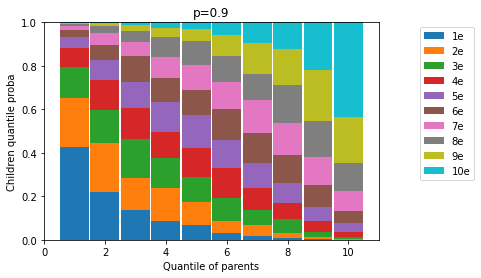

In [109]:
#number of quantiles (number of income classes)
nb_quantiles = 10

#sample size
n = 1000 * nb_quantiles  

#calculation
y_child, y_parents = generate_incomes(n, pj)

sample = compute_quantiles(y_child, y_parents, nb_quantiles)

cd = conditional_distributions(sample, nb_quantiles)

plot_conditional_distributions(pj, cd, nb_quantiles)

#### Task 3.7
Eventually and to avoid any confusion, delete the individuals you have just generated (we no longer need them), and only keep the conditional distributions.

In [110]:
del y_parents, y_child

#### Task 3.8
We will now work on a new sample. This will be created from the WID. For each individual in the World Income Distribution, create 499 "clones". The size of your new sample will therefore be 500 times larger than that of the World Income Distribution.

In [111]:
# chaque percentile est un enfant individuel 
# each percentile is an individual child 
df_q4 = df_global4[['country_name', 'country', 'quantile', 'income', 'elasticity', 'region']]
df_q4 = df_q4.rename(columns={'quantile':'c_i_child', 'income':'y_child'})
df_q4 = df_q4[['country_name', 'country', 'region', 'c_i_child', 'y_child', 'elasticity']]

# créer 500 copies de chaque
# create 500 copies of each
df_q4 = pd.concat([df_q4] * 500, ignore_index=True)

# dtypes fix
df_q4['country'] = df_q4['country'].astype('category')
df_q4['c_i_child'] = df_q4['c_i_child'].astype('int8')

In [112]:
df_q4.head(3)

,country_name,country,region,c_i_child,y_child,elasticity
0,Albania,ALB,Europe,1,728.90,0.82
1,Albania,ALB,Europe,2,916.66,0.82
2,Albania,ALB,Europe,3,"1,010.92",0.82


#### Task 3.9
For each \(c_{i,child}\) and each country, there are now 500 individuals. You will assign the 500 individuals their classes \( c_{i,parent}\) according to the distributions found previously. For example, if \(P(c_{i,parent}=8|c_{i,child}=5,\rho_j=0.9) = 0.03\) , then you would assign the class \(c_{i,parent} = 8\) to 15 of the 500 individuals in country \( j\) having \(c_{i,child}=5\) , because 500*0.03 = 15.

In [113]:
def c_i_parent(y_child, pj, alpha=0, nb_quantiles=100):
    
    #sample size
    size = len(y_child)
    
    #quantiles
    quantiles = np.round(np.arange(1, nb_quantiles+1, nb_quantiles/size)- 0.5 + 1./size)
    
    #generation of a realization of the error term epsilon
    epsilon = st.norm(0,1).rvs(size)
    
    #calculation of y_parent
    y_parent = [np.exp((np.log(x) - alpha - y)/pj) for x, y in zip(y_child, epsilon)]
    
    #dict() c_i_parent
    q_dict = {a : int(b) for a, b in zip(np.sort(y_parent), quantiles)}
    
    #list() c_i_parent
    return [q_dict[e] for e in y_parent]

In [114]:
%%time

p_j = {x : y for x, y in zip(df_q4[['country', 'elasticity']].drop_duplicates()['country'], df_q4[['country', 'elasticity']].drop_duplicates()['elasticity'])}

centiles_parent = np.array([], dtype=int)

for i in df_q4['country'].unique():
    centiles_parent = np.append(centiles_parent, c_i_parent(df_q4[df_q4['country'] == i]['y_child'], p_j[i] , alpha=2), axis = 0)

Wall time: 41.6 s


In [115]:
df_q4["c_i_parent"] = centiles_parent
df_q4.sample(5)

,country_name,country,region,c_i_child,y_child,elasticity,c_i_parent
3681426,Hungary,HUN,Europe,27,"4,016.00",0.39,81
3179806,Central African Republic,CAF,Africa,7,113.78,0.71,5
4511410,Uganda,UGA,Africa,11,323.37,1.03,25
175716,China,CHN,Asia,17,666.41,0.40,9
455363,Spain,ESP,Europe,64,"13,904.82",0.42,81


#### Task 3.10
Eventually and to avoid any confusion, delete the variable \(c_{i,child}\) : we don't need it for mission 4.

In [116]:
df_q4 = df_q4.drop(columns='c_i_child')

#### Task 3.11
Make sure that your new sample contains the variables initially present in the World Income Distribution (m_j) and (G_j)\
mj - avg income of the country j\
Gj - Gini index of the country j

In [117]:
#average income
mj = df_global4.groupby('country_name')['income'].mean().reset_index()
mj = mj.rename(columns = {'income' : 'mj'})
mj.sample(5)

,country_name,mj
84,Panama,"5,135.14"
3,Austria,"16,637.60"
51,Israel,"11,100.32"
104,Thailand,"2,743.71"
0,Albania,"2,994.83"


In [118]:
mj.isna().sum()

country_name    0
mj              0
dtype: int64

In [119]:
#gini index
Gj = df_global4.groupby('country_name')['gini_manual'].mean().reset_index()
Gj = Gj.rename(columns = {'gini_manual' : 'Gj'} )
Gj.sample(5)

,country_name,Gj
52,Italy,33.40
60,Lao PDR,37.05
21,"Congo, Dem. Rep.",45.94
109,United Kingdom,35.58
61,Latvia,37.85


In [120]:
Gj.isna().sum()

country_name    0
Gj              0
dtype: int64

In [121]:
#merge
df_q4 = df_q4.merge(mj, on='country_name', how='left')
df_q4 = df_q4.merge(Gj, on='country_name', how='left')

#drop
df_q4 = df_q4.drop(columns='region')

In [122]:
print(df_q4.shape)
display(df_q4.head(3))

(5800000, 7)


,country_name,country,y_child,elasticity,c_i_parent,mj,Gj
0,Albania,ALB,728.90,0.82,2,"2,994.83",32.14
1,Albania,ALB,916.66,0.82,2,"2,994.83",32.14
2,Albania,ALB,"1,010.92",0.82,33,"2,994.83",32.14


In [123]:
# save it to csv

#df_q4.to_csv(workdir + '/data/df_q4_final.csv')

## Task 4

In [124]:
# load data from created csv to save time
df_q4 = pd.read_csv(workdir + '/data/df_q4_final.csv')

Check for normality of the data

<Figure size 1080x720 with 0 Axes>

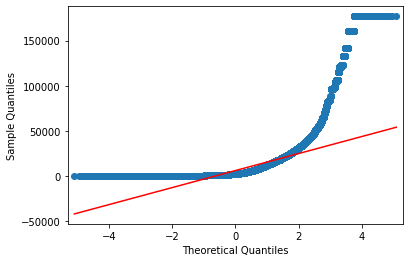

In [125]:
# save data for a test
a = df_q4['y_child'].values

# qq (quantile-quantile) plot
plt.figure(figsize = (15,10))
sm.qqplot(a, line='s') # dist= Comparison distribution. The default is scipy.stats.distributions.norm (a standard normal).
plt.savefig(fname='Income_normality_QQplot.jpg', dpi=100, format='jpg', orientation='landscape', bbox_inches='tight')
plt.show();

Nos données ne suivent pas une distribution normale.\
Our data doesnt follow normal distribution.

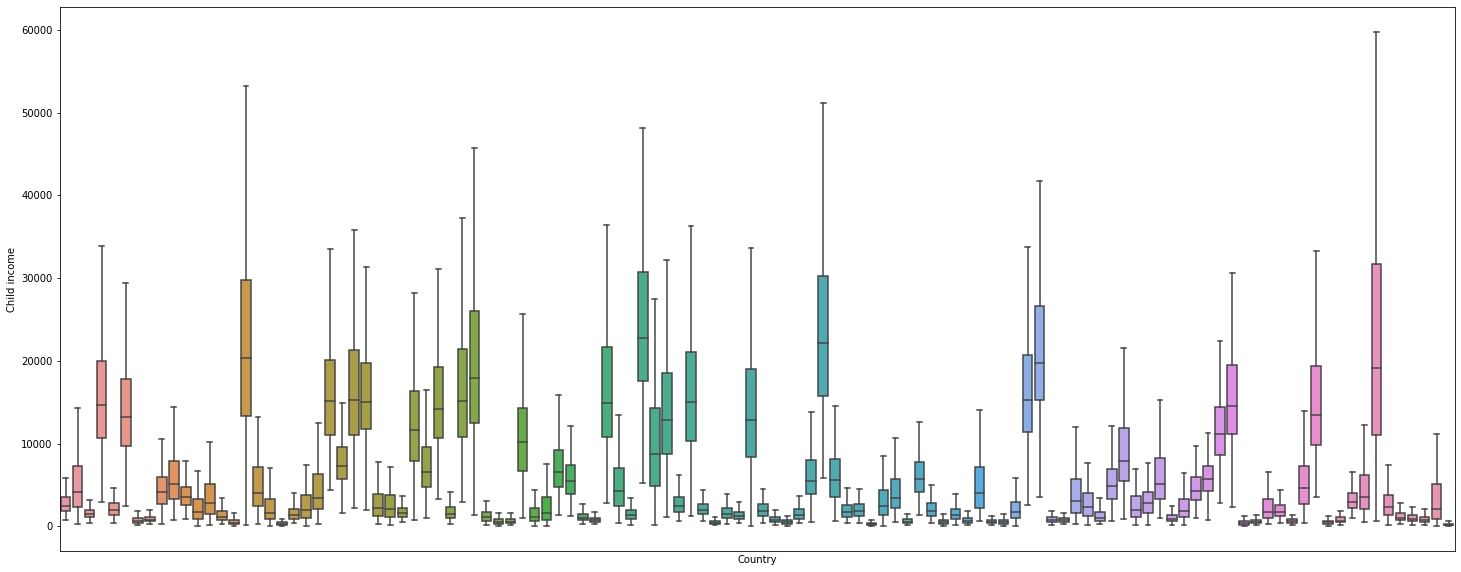

In [126]:
# homoscedasticity

plt.figure(figsize=(25, 10))
sns.boxplot(data=df_q4, x='country_name', y='y_child', showfliers=False)
plt.xticks([]) # empty list to hide country names
plt.xlabel('Country')
plt.ylabel('Child income')
plt.savefig(fname='Income_homoscedasticity.jpg', dpi=100, format='jpg', orientation='landscape', bbox_inches='tight')
plt.show();

Variances are also not equal, as seen from the graph above. Statistical tests can help us proving this.

Bartlett and Levene tests.

In [127]:
pg.homoscedasticity(df_q4, dv='y_child', group='country_name', method='levene', alpha=0.05)

# this test also gives pvalue of 0, meaning variances are not equal

,W,pval,equal_var
levene,"12,688.87",0.00,False


In situation like this (data doesnt follow normal distributions, variances are not equal), we can transform our data, apply central limit theorem (only for large datasets), and use non parametric statistical tests

Data transformation into logarithm scale

In [128]:
df_q4['log_y_child'] = np.log(df_q4['y_child'])
df_q4.sample(3)

,Unnamed: 0,country_name,country,y_child,elasticity,c_i_parent,mj,Gj,log_y_child
5757515,5757515,Guatemala,GTM,461.58,1.02,65,"2,142.47",58.25,6.13
3162512,3162512,Mozambique,MOZ,208.23,0.71,21,692.48,47.17,5.34
3519153,3519153,Indonesia,IDN,"1,039.76",0.45,22,"1,334.62",38.82,6.95


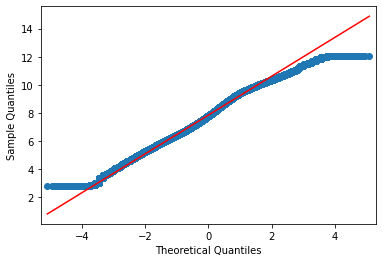

In [129]:
# tester la normalité après la transformation des données
# testing normality after data transformation

sm.qqplot(df_q4['log_y_child'], line='s') # line arg again gives different results?! was q
plt.savefig(fname='Income_log_normality.jpg', dpi=100, format='jpg', orientation='landscape', bbox_inches='tight')
plt.show();

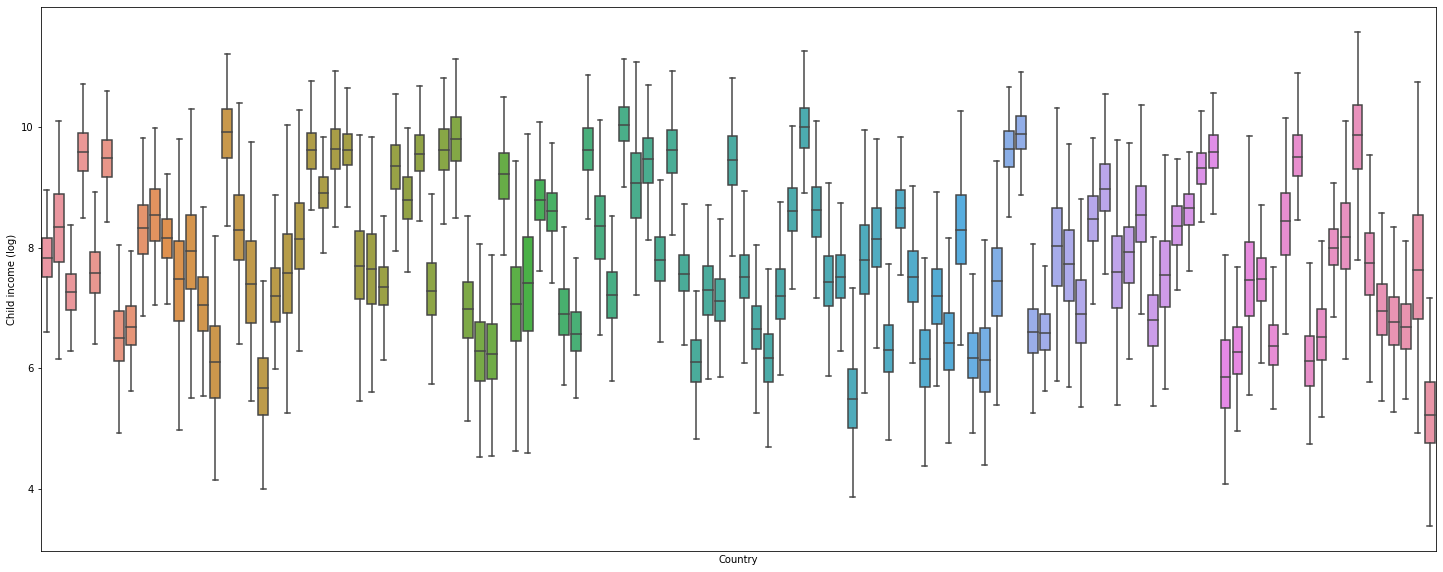

In [130]:
# tester l'homoscédasticité après transformation des données
# testing homoscedasticity after data transformation

plt.figure(figsize=(25, 10))
sns.boxplot(data=df_q4, x='country_name', y='log_y_child', showfliers=False)
plt.xticks([]) # empty list to hide country names
plt.xlabel('Country')
plt.ylabel('Child income (log)')
plt.savefig(fname='Income_log_homoscedasticity.jpg', dpi=100, format='jpg', orientation='landscape', bbox_inches='tight')
plt.show();

This gives us data that is far closer to normal distribution, but it's still not perfect.\
Variances also became better, but far from perfect.

In [131]:
# non parametric statistical test
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.kruskal.html
# https://pingouin-stats.org/generated/pingouin.kruskal.html#pingouin.kruskal

# confidence level
conf_lvl = 0.05

kruskal_test = pg.kruskal(data=df_q4, dv='y_child', between='country_name')
kruskal_test

# 'H': The Kruskal-Wallis H statistic, corrected for ties
# 'p-unc': Uncorrected p-value
# 'dof': degrees of freedom

,Source,ddof1,H,p-unc
Kruskal,country_name,115,"4,297,171.88",0.00


### ANOVA

y_child - income\
c_i_child - quantile

In [132]:
# ANOVA with country as single explanatory variable
pg.anova(data=df_q4, dv='y_child', between='country_name', detailed=True)

# ANOVA summary:
# 'Source': Factor names
# 'SS': Sums of squares
# 'DF': Degrees of freedom
# 'MS': Mean squares
# 'F': F-values
# 'p-unc': uncorrected p-values
# 'np2': Partial eta-square effect sizes

,Source,SS,DF,MS,F,p-unc,np2
0,country_name,"255,118,762,151,916.69",115,"2,218,424,018,712.32","49,710.76",0.00,0.50
1,Within,"258,829,321,031,696.16",5799884,"44,626,637.54",NaN,NaN,NaN


In [133]:
# logarithmic data
pg.anova(data=df_q4, dv='log_y_child', between='country_name', detailed=False)

,Source,ddof1,ddof2,F,p-unc,np2
0,country_name,115,5799884,"135,832.37",0.00,0.73


ANOVA performs much better with logaritmic data, compared to initial data (0.73 eta-sq versus 0.5 eta-sq).

### Linear regression v1

In [134]:
# v1 is predicting y_child using Gj (gini) and mj (income)

regr_v1 = smf.ols('y_child ~ Gj + mj', data=df_q4).fit()
regr_v1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                y_child   R-squared:                       0.496
Model:                            OLS   Adj. R-squared:                  0.496
Method:                 Least Squares   F-statistic:                 2.858e+06
Date:                Mon, 28 Feb 2022   Prob (F-statistic):               0.00
Time:                        03:44:06   Log-Likelihood:            -5.9310e+07
No. Observations:             5800000   AIC:                         1.186e+08
Df Residuals:                 5799997   BIC:                         1.186e+08
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -2.167e-08     14.699  -1.47e-09      1.000     -28.809      28.809
Gj          4.163e-10      0.335   1.24e-09      1.000      -0.657       0.657
mj             1.0000      0.000   2234.874      0.000       0.999       1.001
==============================================================================
Omnibus:                  7299083.278   Durbin-Watson:                   0.685
Prob(Omnibus):                  0.000   Jarque-Bera (JB):       2103715771.076
Skew:                           6.739   Prob(JB):                         0.00
Kurtosis:                      95.322   Cond. No.                     4.77e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.77e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

R au carré est de 0,496, très faible comme prévu (pour les données initiales non logarithmiques).\
R squared is 0.496, very low as expected (for initial non log data).

In [135]:
# decomposition of variances

def decomposition_of_variances(MLR) :
    data = sm.stats.anova_lm(MLR, typ=1)
    ssq = data[['sum_sq']]
    ssq = np.round(100 * ssq / ssq.sum(), 3)
    ssq['sum_sq'] = ssq.sum_sq
    ssq.columns = ['Explained Variance (%)']
    return(ssq)

In [136]:
decomposition_of_variances(regr_v1)

,Explained Variance (%)
Gj,6.27
mj,43.37
Residual,50.36


### Linear regression v2

In [137]:
# transform data for the log scale
df_q4['log_y_child'] = np.log(df_q4['y_child'])
df_q4['log_mj'] = np.log(df_q4['mj'])

In [138]:
regr_v2 = smf.ols('log_y_child ~ log_mj + Gj', data=df_q4).fit()
regr_v2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            log_y_child   R-squared:                       0.729
Model:                            OLS   Adj. R-squared:                  0.729
Method:                 Least Squares   F-statistic:                 7.793e+06
Date:                Mon, 28 Feb 2022   Prob (F-statistic):               0.00
Time:                        03:44:11   Log-Likelihood:            -6.3181e+06
No. Observations:             5800000   AIC:                         1.264e+07
Df Residuals:                 5799997   BIC:                         1.264e+07
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.4961      0.003    170.994      0.000       0.490       0.502
log_mj         0.9864      0.000   3651.055      0.000       0.986       0.987
Gj            -0.0165    3.5e-05   -471.886      0.000      -0.017      -0.016
==============================================================================
Omnibus:                   372790.841   Durbin-Watson:                   0.390
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1752380.549
Skew:                          -0.081   Prob(JB):                         0.00
Kurtosis:                       5.688   Cond. No.                         402.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [139]:
decomposition_of_variances(regr_v2)

,Explained Variance (%)
log_mj,71.84
Gj,1.04
Residual,27.12


Le modèle v2 est beaucoup plus performant (0.729) grâce à la transformation logarithmique des données, mais l'indice de Gini (Gj) n'a qu'un effet de 1%.\
v2 model performs much better (0.729) thanks for logarithmic transformation of data, but Gini index (Gj) has only 1% effect

### Linear regression v3

In [140]:
regr_v3 = smf.ols('log_y_child ~ log_mj + Gj + c_i_parent', data=df_q4).fit()
regr_v3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            log_y_child   R-squared:                       0.800
Model:                            OLS   Adj. R-squared:                  0.800
Method:                 Least Squares   F-statistic:                 7.732e+06
Date:                Mon, 28 Feb 2022   Prob (F-statistic):               0.00
Time:                        03:44:16   Log-Likelihood:            -5.4354e+06
No. Observations:             5800000   AIC:                         1.087e+07
Df Residuals:                 5799996   BIC:                         1.087e+07
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.1479      0.003    -58.432      0.000      -0.153      -0.143
log_mj         0.9862      0.000   4250.672      0.000       0.986       0.987
Gj            -0.0165   3.01e-05   -548.965      0.000      -0.017      -0.016
c_i_parent     0.0128   8.88e-06   1436.507      0.000       0.013       0.013
==============================================================================
Omnibus:                   423568.092   Durbin-Watson:                   0.826
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          2077330.002
Skew:                          -0.168   Prob(JB):                         0.00
Kurtosis:                       5.913   Cond. No.                         682.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [141]:
decomposition_of_variances(regr_v3)

,Explained Variance (%)
log_mj,71.84
Gj,1.04
c_i_parent,7.12
Residual,20.00


Le modèle v3 est légèrement plus performant (0.8), mais Gini n'a à nouveau qu'un effet minime de 1% en termes de variance.\
Les valeurs P pour les variables du modèle sont de 0, ce qui signifie qu'elles sont importantes pour celui-ci.

v3 model performs slightly better (0.8), but Gini again has very small effect of 1% in terms of variance.\
Pvalues for model vars are 0, meaning they are important for it.

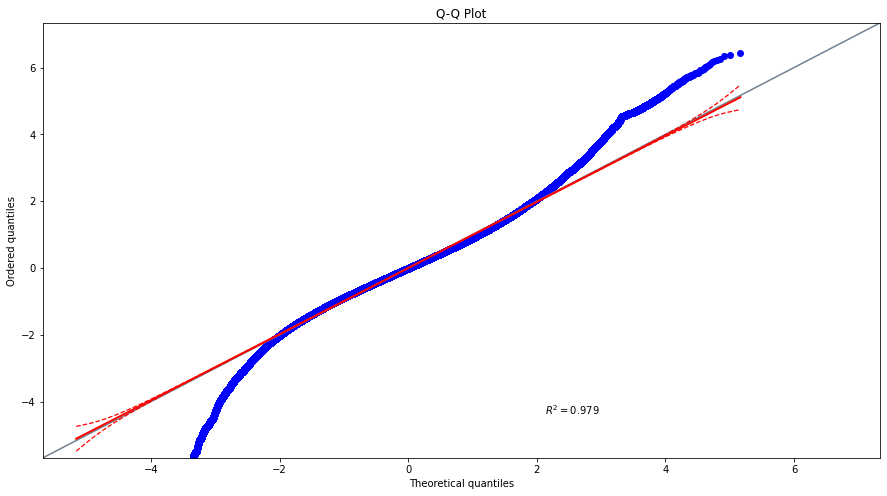

In [142]:
# distribution des résidus
# distribution of residuals

pg.qqplot(regr_v3.resid, dist='norm', figsize=(15,8))
plt.savefig(fname='Residuals_distribution_normality.jpg', dpi=100, format='jpg', orientation='landscape', bbox_inches='tight')
plt.show();

#### residuals homoscedasticity

In [143]:
def residual_variance(MODEL):
    plt.figure(figsize=(10,5))
    plt.plot(MODEL.fittedvalues, MODEL.resid, ".", alpha=0.3)
    plt.title("Residual variance cloud", fontsize=18)
    plt.xlabel("Income", fontsize=16)
    plt.ylabel("Residuals", fontsize=16)
    plt.savefig(fname='Residuals_variance_cloud.jpg', dpi=100, format='jpg', orientation='landscape', bbox_inches='tight')

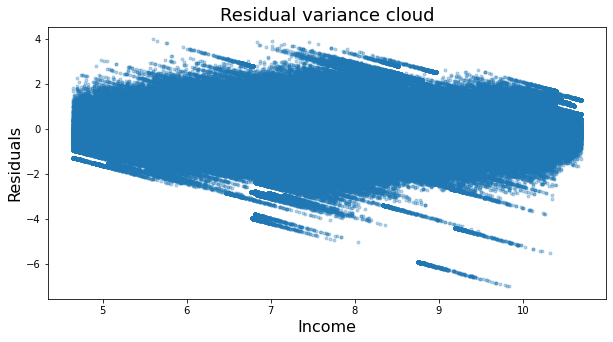

In [144]:
residual_variance(regr_v3)

In [145]:
# https://www.statsmodels.org/stable/generated/statsmodels.stats.diagnostic.het_breuschpagan.html

variables = regr_v3.model.exog
lm, lm_pvalue, fvalue, f_pvalue = statsmodels.stats.diagnostic.het_breuschpagan(regr_v3.resid, variables)

print('p-value of Breusch Pagan test:', lm_pvalue)

# returns
# lmfloat - lagrange multiplier statistic
# lm_pvaluefloat - p-value of lagrange multiplier test
# fvaluefloat - f-statistic of the hypothesis that the error variance does not depend on x
# f_pvaluefloat - p-value for the f-statistic

p-value of Breusch Pagan test: 0.0


p-value < 5% (it is 0). We reject H0 that the variances are constant (the homoscedasticity hypothesis)

#### collinearity

In [146]:
def VIF(MLR, variables):
    MEX = MLR.model.exog
    return(pd.DataFrame({'VIF' : [variance_inflation_factor(MEX, i) for i in np.arange(1, MEX.shape[1])]}, index=variables))

In [147]:
VIF(regr_v3, ['log_mj', 'Gj', 'c_i_parent'])

,VIF
log_mj,1.08
Gj,1.08
c_i_parent,1.00


Conclusions:

Globalement, nous pouvons voir que les données brutes ne sont pas très performantes avec nos modèles. Après normalisation, les performances peuvent être améliorées.
Le troisième modèle de régression linéaire a la meilleure performance (0.8). Les variables ont des valeurs p de 0, ce qui signifie qu'elles fonctionnent pour notre modèle.
Cependant, en termes d'impact, nous pouvons voir que le revenu est le facteur principal pour prédire le revenu d'un enfant, l'indice de Gini a un impact minimal, le quantile parental n'en est pas loin, le reste dépend d'autres facteurs, selon le modèle.

Overall we can see that raw data is not performing well with our models. After normalization performance can be improved.
Third linear regression model has the best performance (0.8). Variables have pvalues of 0 meaning they do work for our model.
However in terms of impact we can see that income is the major factor in predicting income of a child, gini index has minimal impact, parental quantile is not far from it, the rest depends on other factors, according to the model.